### <center>Demand estimation for food distribution in schools-Part2</center>
<center>Operations Analytics - Prof Debjit Roy: Group Assignment 6</center>
<center>ePGD ABA 2020-21</center>
<center>Review made by Kanika Gupta (aba20kanikag@iima.ac.in) & Abhilash Agnihotri (aba20akshays@iima.ac.in)</center>

In [1]:
# !pip install --quiet feature_engine
# !pip install --quiet feature_engine --upgrade --no-deps
# !pip install --quiet sklearn
# !pip install --quiet sklearn --upgrade --no-deps
# !pip install --quiet xgboost
# !pip install --quiet lightgbm
# !pip install --quiet imblearn
# !pip install --quiet scikit-plot
# !pip install --quiet catboost

In [2]:
##Import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import math
import requests
from io import StringIO
import sys

from pandas import ExcelWriter
# import xlsxwriter

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

In [4]:
import xgboost as xgb
from sklearn.feature_selection import RFECV
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

In [6]:
#Import data
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/articles/ml_inputs_akshaypatra.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0, index_col=None)

In [7]:
dataset.head()

,school_id_masked,ben_date,censored,mixed_demand,cluster_id,tot_enrol,s_1_5_boys,s_1_5_girls,s_6_8_boys,s_6_8_girls,...,prop_grp_mnth_dd,prop_grp_boys15,prop_grp_girls15,prop_grp_boys68,prop_grp_girls68,prop_wk_boys15,prop_wk_girls15,prop_wk_boys68,prop_wk_girls68,true_demand
0,ZYD-CU8,12/29/2014,1,41.60,0,515,174,120,129,92,...,0.11,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,49.98
1,ZYD-CU8,3/7/2015,0,19.12,0,515,174,120,129,92,...,0.05,0.02,0.02,0.02,0.02,0.03,0.04,0.03,0.04,19.12
2,ZYD-CU8,6/8/2015,0,7.91,0,515,174,120,129,92,...,0.13,0.02,0.02,0.02,0.02,0.04,0.04,0.04,0.04,7.91
3,ZYD-CU8,6/11/2015,1,17.80,0,515,174,120,129,92,...,0.13,0.02,0.02,0.02,0.02,0.04,0.04,0.04,0.04,32.75
4,ZYD-CU8,6/15/2015,0,2.58,0,515,174,120,129,92,...,0.13,0.02,0.02,0.02,0.02,0.03,0.02,0.03,0.03,2.58


In [8]:
# Checking Null values
dataset.isnull().sum()*100/dataset.shape[0]

school_id_masked    0.0
ben_date            0.0
censored            0.0
mixed_demand        0.0
cluster_id          0.0
tot_enrol           0.0
s_1_5_boys          0.0
s_1_5_girls         0.0
s_6_8_boys          0.0
s_6_8_girls         0.0
loc_type            0.0
school_grp          0.0
Month               0.0
Day                 0.0
Week                0.0
Year                0.0
lag1_grp_mnth_dd    0.0
lag2_grp_mnth_dd    0.0
lag3_grp_mnth_dd    0.0
prop_grp_mnth_dd    0.0
prop_grp_boys15     0.0
prop_grp_girls15    0.0
prop_grp_boys68     0.0
prop_grp_girls68    0.0
prop_wk_boys15      0.0
prop_wk_girls15     0.0
prop_wk_boys68      0.0
prop_wk_girls68     0.0
true_demand         0.0
dtype: float64

In [9]:
dataset.drop(labels=["true_demand", "cluster_id"], inplace=True, axis=1)

In [10]:
dataset.head()

,school_id_masked,ben_date,censored,mixed_demand,tot_enrol,s_1_5_boys,s_1_5_girls,s_6_8_boys,s_6_8_girls,loc_type,...,lag3_grp_mnth_dd,prop_grp_mnth_dd,prop_grp_boys15,prop_grp_girls15,prop_grp_boys68,prop_grp_girls68,prop_wk_boys15,prop_wk_girls15,prop_wk_boys68,prop_wk_girls68
0,ZYD-CU8,12/29/2014,1,41.60,515,174,120,129,92,Urban,...,0.00,0.11,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01
1,ZYD-CU8,3/7/2015,0,19.12,515,174,120,129,92,Urban,...,89.20,0.05,0.02,0.02,0.02,0.02,0.03,0.04,0.03,0.04
2,ZYD-CU8,6/8/2015,0,7.91,515,174,120,129,92,Urban,...,34.74,0.13,0.02,0.02,0.02,0.02,0.04,0.04,0.04,0.04
3,ZYD-CU8,6/11/2015,1,17.80,515,174,120,129,92,Urban,...,34.74,0.13,0.02,0.02,0.02,0.02,0.04,0.04,0.04,0.04
4,ZYD-CU8,6/15/2015,0,2.58,515,174,120,129,92,Urban,...,34.74,0.13,0.02,0.02,0.02,0.02,0.03,0.02,0.03,0.03


In [11]:
dataset.shape

(6138, 27)

In [12]:
dataset['Month'] = dataset['Month'].astype("O")
dataset['Day'] = dataset['Day'].astype("O")
dataset['Week'] = dataset['Week'].astype("O")
dataset['Year'] = dataset['Year'].astype("O")

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
##Separate target and predictors from train data
y = dataset.loc[:, ["mixed_demand"]]
X_copy = dataset.copy()
X = X_copy.drop(["mixed_demand", "school_id_masked", "ben_date", "tot_enrol"], axis=1)

##Create train set and validation set from train_data for model diagnostics before using actual test_data
##Push 40% to validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.30, random_state = 0)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((4296, 23), (1842, 23), (4296, 1), (1842, 1))

In [15]:
X_valid1, X_test, y_valid1, y_test = train_test_split(X_valid, y_valid, test_size = 0.50, random_state = 0)

In [16]:
X_valid1.shape, X_test.shape, y_valid1.shape, y_test.shape

((921, 23), (921, 23), (921, 1), (921, 1))

In [17]:
del X_valid, y_valid

In [18]:
X_valid = X_valid1.copy()
y_valid = y_valid1.copy()

In [19]:
X_train.shape, X_valid.shape, X_test.shape

((4296, 23), (921, 23), (921, 23))

In [20]:
y_train.shape, y_valid.shape, y_test.shape

((4296, 1), (921, 1), (921, 1))

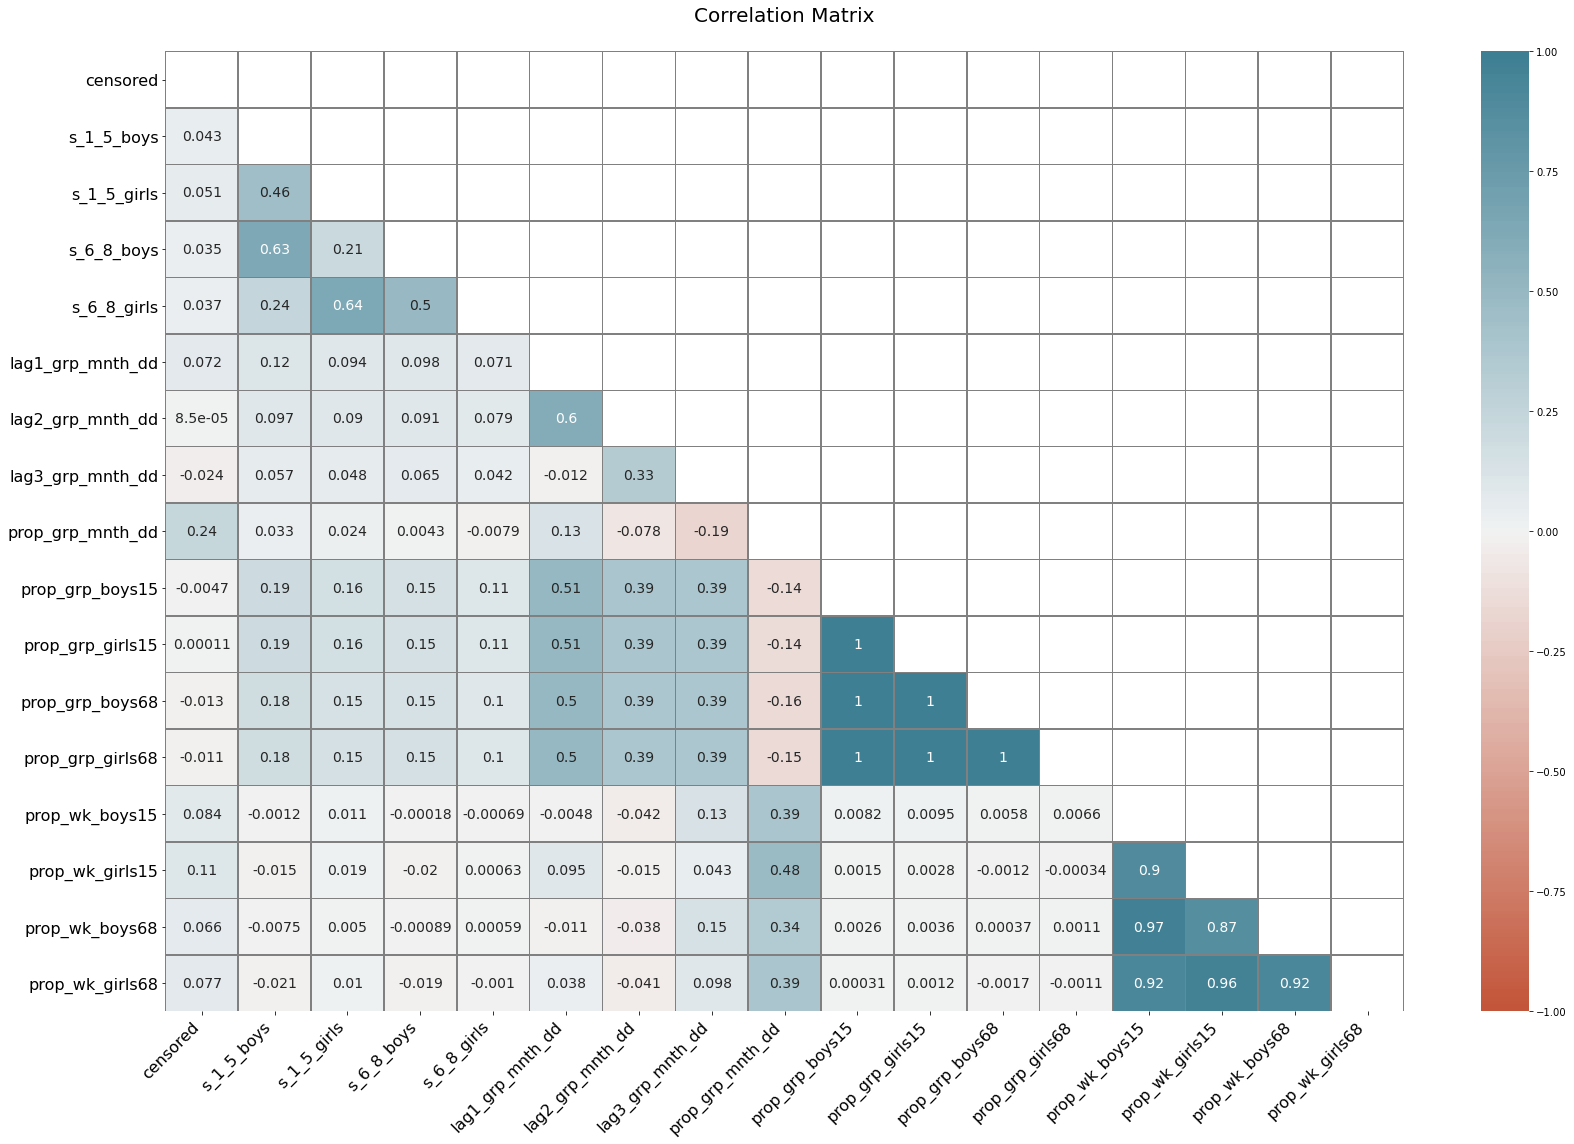

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(24, 16))
cormat = X_train.corr()
sns.heatmap(cormat,
            cmap=sns.diverging_palette(20, 220, n=200),
            annot = True,
            annot_kws={"size": 14},
            linewidths=0.5,
            vmin=-1, vmax=1, center= 0,
            linecolor='grey',
            mask=np.triu(cormat),
            ax=ax)
ax.set_title('Correlation Matrix', fontsize=20, pad=30)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right', fontsize = 16)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 16)
fig.tight_layout()
plt.show()

**Before winsorization of school enrollments for boys and girls**

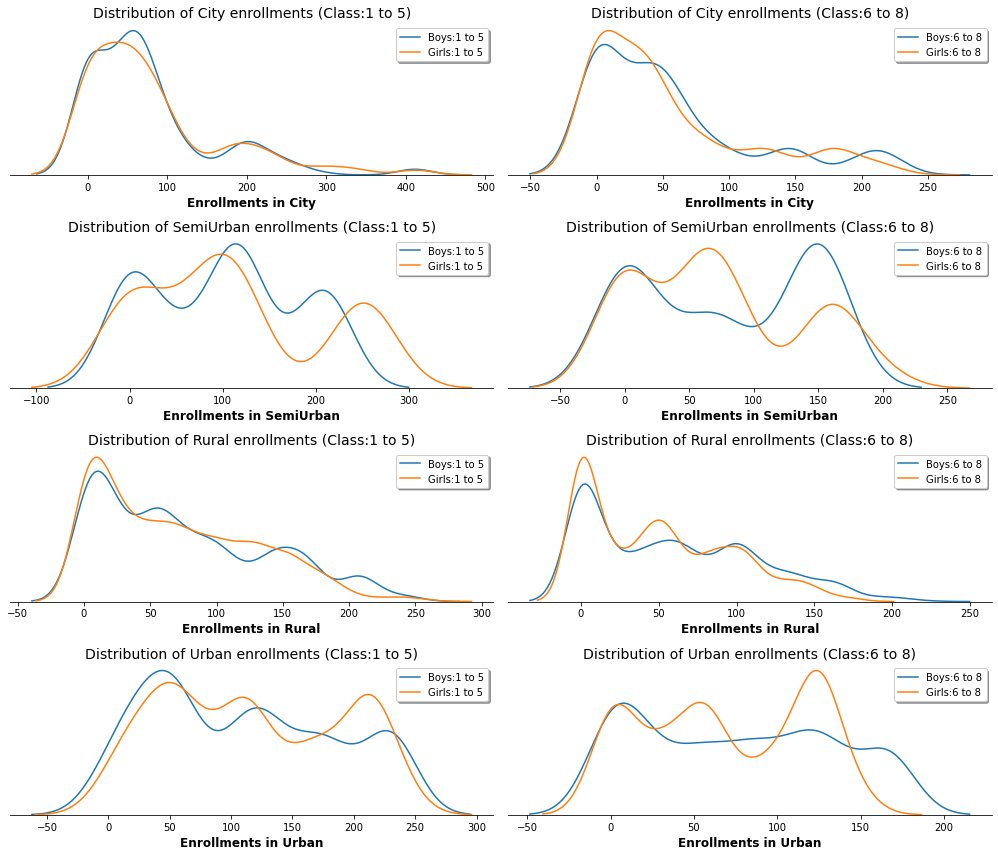

In [22]:
# X_train.loc[X_train['Loc_type']=="City", "S_1_5_Boys"]
##Create the grid
fig, axes = plt.subplots(4, 2, figsize=(14,12))
fig.subplots_adjust(top=0.7)

##1st row
x1data=X_train.loc[X_train['loc_type']=="City", "s_1_5_boys"]
x2data=X_train.loc[X_train['loc_type']=="City", "s_1_5_girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[0,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[0,0]);
axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['left'].set_visible(False)
axes[0,0].axes.get_yaxis().set_visible(False)
axes[0,0].set_title('Distribution of City enrollments (Class:1 to 5)', fontsize=14)
axes[0,0].set_xlabel('Enrollments in City', fontsize=12, weight='bold')
axes[0,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=X_train.loc[X_train['loc_type']=="City", "s_6_8_boys"]
x2data=X_train.loc[X_train['loc_type']=="City", "s_6_8_girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[0,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[0,1]);
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['left'].set_visible(False)
axes[0,1].axes.get_yaxis().set_visible(False)
axes[0,1].set_title('Distribution of City enrollments (Class:6 to 8)', fontsize=14)
axes[0,1].set_xlabel('Enrollments in City', fontsize=12, weight='bold')
axes[0,1].legend(loc='best', shadow=True,fontsize='medium')

##2nd row
x1data=X_train.loc[X_train['loc_type']=="SemiUrban", "s_1_5_boys"]
x2data=X_train.loc[X_train['loc_type']=="SemiUrban", "s_1_5_girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[1,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[1,0]);
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['left'].set_visible(False)
axes[1,0].axes.get_yaxis().set_visible(False)
axes[1,0].set_title('Distribution of SemiUrban enrollments (Class:1 to 5)', fontsize=14)
axes[1,0].set_xlabel('Enrollments in SemiUrban', fontsize=12, weight='bold')
axes[1,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=X_train.loc[X_train['loc_type']=="SemiUrban", "s_6_8_boys"]
x2data=X_train.loc[X_train['loc_type']=="SemiUrban", "s_6_8_girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[1,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[1,1]);
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['left'].set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
axes[1,1].set_title('Distribution of SemiUrban enrollments (Class:6 to 8)', fontsize=14)
axes[1,1].set_xlabel('Enrollments in SemiUrban', fontsize=12, weight='bold')
axes[1,1].legend(loc='best', shadow=True,fontsize='medium')

##3rd row
x1data=X_train.loc[X_train['loc_type']=="Rural", "s_1_5_boys"]
x2data=X_train.loc[X_train['loc_type']=="Rural", "s_1_5_girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[2,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[2,0]);
axes[2,0].spines['top'].set_visible(False)
axes[2,0].spines['right'].set_visible(False)
axes[2,0].spines['left'].set_visible(False)
axes[2,0].axes.get_yaxis().set_visible(False)
axes[2,0].set_title('Distribution of Rural enrollments (Class:1 to 5)', fontsize=14)
axes[2,0].set_xlabel('Enrollments in Rural', fontsize=12, weight='bold')
axes[2,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=X_train.loc[X_train['loc_type']=="Rural", "s_6_8_boys"]
x2data=X_train.loc[X_train['loc_type']=="Rural", "s_6_8_girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[2,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[2,1]);
axes[2,1].spines['top'].set_visible(False)
axes[2,1].spines['right'].set_visible(False)
axes[2,1].spines['left'].set_visible(False)
axes[2,1].axes.get_yaxis().set_visible(False)
axes[2,1].set_title('Distribution of Rural enrollments (Class:6 to 8)', fontsize=14)
axes[2,1].set_xlabel('Enrollments in Rural', fontsize=12, weight='bold')
axes[2,1].legend(loc='best', shadow=True,fontsize='medium')

##4th row
x1data=X_train.loc[X_train['loc_type']=="Urban", "s_1_5_boys"]
x2data=X_train.loc[X_train['loc_type']=="Urban", "s_1_5_girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[3,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[3,0]);
axes[3,0].spines['top'].set_visible(False)
axes[3,0].spines['right'].set_visible(False)
axes[3,0].spines['left'].set_visible(False)
axes[3,0].axes.get_yaxis().set_visible(False)
axes[3,0].set_title('Distribution of Urban enrollments (Class:1 to 5)', fontsize=14)
axes[3,0].set_xlabel('Enrollments in Urban', fontsize=12, weight='bold')
axes[3,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=X_train.loc[X_train['loc_type']=="Urban", "s_6_8_boys"]
x2data=X_train.loc[X_train['loc_type']=="Urban", "s_6_8_girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[3,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[3,1]);
axes[3,1].spines['top'].set_visible(False)
axes[3,1].spines['right'].set_visible(False)
axes[3,1].spines['left'].set_visible(False)
axes[3,1].axes.get_yaxis().set_visible(False)
axes[3,1].set_title('Distribution of Urban enrollments (Class:6 to 8)', fontsize=14)
axes[3,1].set_xlabel('Enrollments in Urban', fontsize=12, weight='bold')
axes[3,1].legend(loc='best', shadow=True,fontsize='medium')

fig.tight_layout()
plt.show()

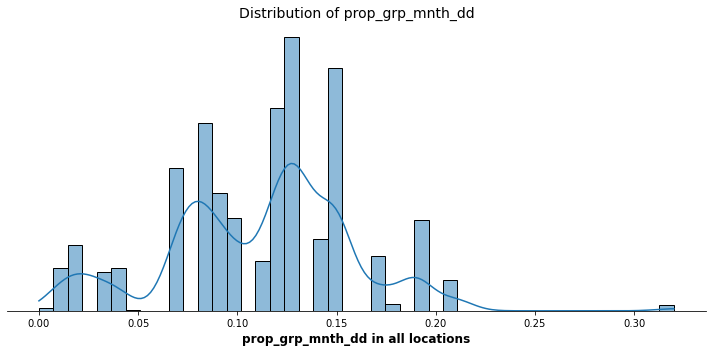

In [23]:
fig, axes = plt.subplots(figsize=(10,5))
fig.subplots_adjust(top=0.7)
sns.histplot (X_train.prop_grp_mnth_dd, ax=axes, kde=True);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.axes.get_yaxis().set_visible(False)
axes.set_title('Distribution of prop_grp_mnth_dd', fontsize=14)
axes.set_xlabel('prop_grp_mnth_dd in all locations', fontsize=12, weight='bold')
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

In [24]:
from feature_engine.outliers import Winsorizer

In [25]:
# Outlier handling for school enrollments absolute values for boys and girls
windsoriser = Winsorizer(capping_method='quantiles',
                          tail='both',
                          fold=0.05,
                          variables=['s_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
                                    'prop_grp_mnth_dd'])
windsoriser.fit(X_train)

Winsorizer(capping_method='quantiles', fold=0.05, tail='both',
           variables=['s_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
                      'prop_grp_mnth_dd'])

In [26]:
windsoriser_train = windsoriser.transform(X_train)
windsoriser_valid = windsoriser.transform(X_valid)
windsoriser_test = windsoriser.transform(X_test)

**After winsorization of school enrollments for boys and girls**

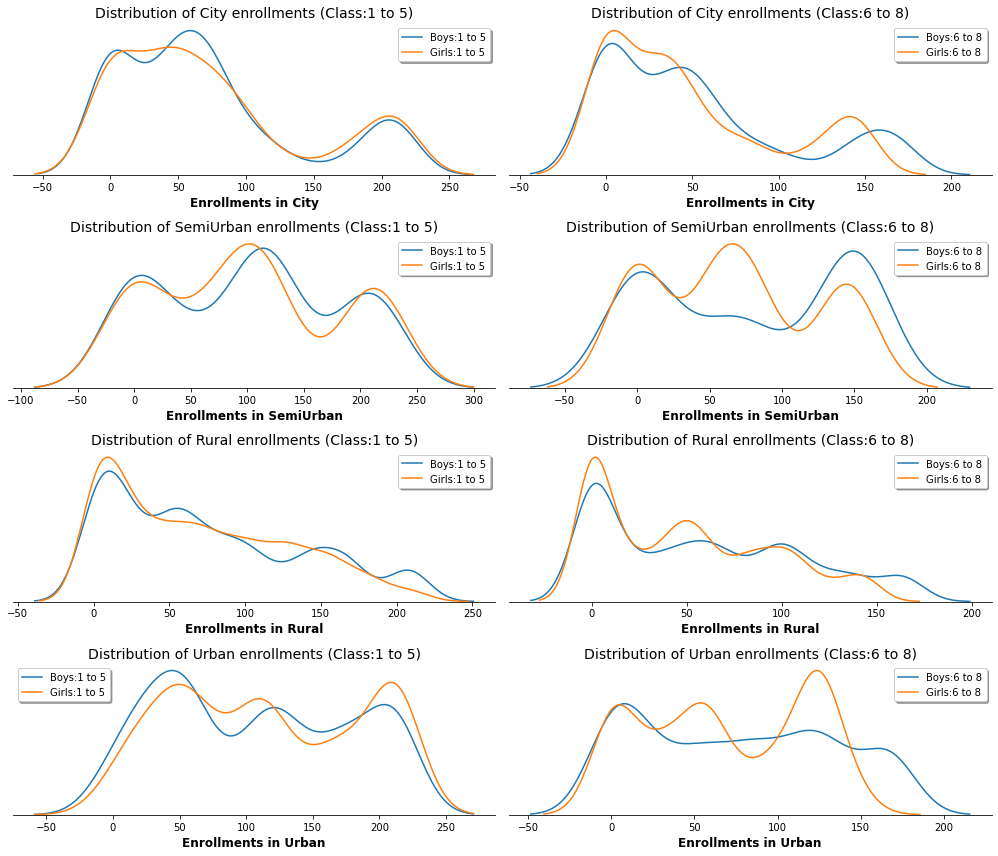

In [27]:
# windsoriser_train.loc[windsoriser_train['Loc_type']=="City", "S_1_5_Boys"]
##Create the grid
fig, axes = plt.subplots(4, 2, figsize=(14,12))
fig.subplots_adjust(top=0.7)

##1st row
x1data=windsoriser_train.loc[windsoriser_train['loc_type']=="City", "s_1_5_boys"]
x2data=windsoriser_train.loc[windsoriser_train['loc_type']=="City", "s_1_5_girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[0,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[0,0]);
axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['left'].set_visible(False)
axes[0,0].axes.get_yaxis().set_visible(False)
axes[0,0].set_title('Distribution of City enrollments (Class:1 to 5)', fontsize=14)
axes[0,0].set_xlabel('Enrollments in City', fontsize=12, weight='bold')
axes[0,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=windsoriser_train.loc[windsoriser_train['loc_type']=="City", "s_6_8_boys"]
x2data=windsoriser_train.loc[windsoriser_train['loc_type']=="City", "s_6_8_girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[0,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[0,1]);
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['left'].set_visible(False)
axes[0,1].axes.get_yaxis().set_visible(False)
axes[0,1].set_title('Distribution of City enrollments (Class:6 to 8)', fontsize=14)
axes[0,1].set_xlabel('Enrollments in City', fontsize=12, weight='bold')
axes[0,1].legend(loc='best', shadow=True,fontsize='medium')

##2nd row
x1data=windsoriser_train.loc[windsoriser_train['loc_type']=="SemiUrban", "s_1_5_boys"]
x2data=windsoriser_train.loc[windsoriser_train['loc_type']=="SemiUrban", "s_1_5_girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[1,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[1,0]);
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['left'].set_visible(False)
axes[1,0].axes.get_yaxis().set_visible(False)
axes[1,0].set_title('Distribution of SemiUrban enrollments (Class:1 to 5)', fontsize=14)
axes[1,0].set_xlabel('Enrollments in SemiUrban', fontsize=12, weight='bold')
axes[1,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=windsoriser_train.loc[windsoriser_train['loc_type']=="SemiUrban", "s_6_8_boys"]
x2data=windsoriser_train.loc[windsoriser_train['loc_type']=="SemiUrban", "s_6_8_girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[1,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[1,1]);
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['left'].set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
axes[1,1].set_title('Distribution of SemiUrban enrollments (Class:6 to 8)', fontsize=14)
axes[1,1].set_xlabel('Enrollments in SemiUrban', fontsize=12, weight='bold')
axes[1,1].legend(loc='best', shadow=True,fontsize='medium')

##3rd row
x1data=windsoriser_train.loc[windsoriser_train['loc_type']=="Rural", "s_1_5_boys"]
x2data=windsoriser_train.loc[windsoriser_train['loc_type']=="Rural", "s_1_5_girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[2,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[2,0]);
axes[2,0].spines['top'].set_visible(False)
axes[2,0].spines['right'].set_visible(False)
axes[2,0].spines['left'].set_visible(False)
axes[2,0].axes.get_yaxis().set_visible(False)
axes[2,0].set_title('Distribution of Rural enrollments (Class:1 to 5)', fontsize=14)
axes[2,0].set_xlabel('Enrollments in Rural', fontsize=12, weight='bold')
axes[2,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=windsoriser_train.loc[windsoriser_train['loc_type']=="Rural", "s_6_8_boys"]
x2data=windsoriser_train.loc[windsoriser_train['loc_type']=="Rural", "s_6_8_girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[2,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[2,1]);
axes[2,1].spines['top'].set_visible(False)
axes[2,1].spines['right'].set_visible(False)
axes[2,1].spines['left'].set_visible(False)
axes[2,1].axes.get_yaxis().set_visible(False)
axes[2,1].set_title('Distribution of Rural enrollments (Class:6 to 8)', fontsize=14)
axes[2,1].set_xlabel('Enrollments in Rural', fontsize=12, weight='bold')
axes[2,1].legend(loc='best', shadow=True,fontsize='medium')

##4th row
x1data=windsoriser_train.loc[windsoriser_train['loc_type']=="Urban", "s_1_5_boys"]
x2data=windsoriser_train.loc[windsoriser_train['loc_type']=="Urban", "s_1_5_girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[3,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[3,0]);
axes[3,0].spines['top'].set_visible(False)
axes[3,0].spines['right'].set_visible(False)
axes[3,0].spines['left'].set_visible(False)
axes[3,0].axes.get_yaxis().set_visible(False)
axes[3,0].set_title('Distribution of Urban enrollments (Class:1 to 5)', fontsize=14)
axes[3,0].set_xlabel('Enrollments in Urban', fontsize=12, weight='bold')
axes[3,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=windsoriser_train.loc[windsoriser_train['loc_type']=="Urban", "s_6_8_boys"]
x2data=windsoriser_train.loc[windsoriser_train['loc_type']=="Urban", "s_6_8_girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[3,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[3,1]);
axes[3,1].spines['top'].set_visible(False)
axes[3,1].spines['right'].set_visible(False)
axes[3,1].spines['left'].set_visible(False)
axes[3,1].axes.get_yaxis().set_visible(False)
axes[3,1].set_title('Distribution of Urban enrollments (Class:6 to 8)', fontsize=14)
axes[3,1].set_xlabel('Enrollments in Urban', fontsize=12, weight='bold')
axes[3,1].legend(loc='best', shadow=True,fontsize='medium')

fig.tight_layout()
plt.show()

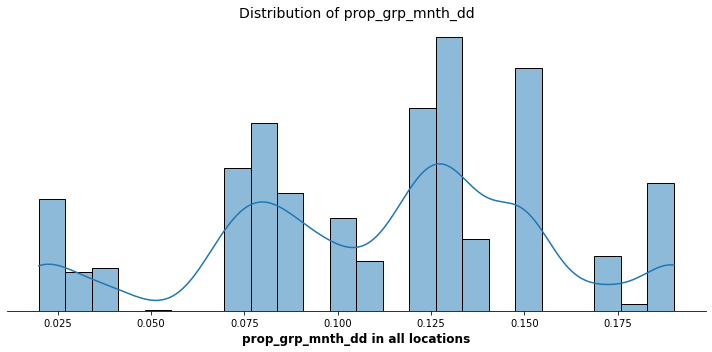

In [28]:
fig, axes = plt.subplots(figsize=(10,5))
fig.subplots_adjust(top=0.7)
sns.histplot (windsoriser_train.prop_grp_mnth_dd, ax=axes, kde=True);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.axes.get_yaxis().set_visible(False)
axes.set_title('Distribution of prop_grp_mnth_dd', fontsize=14)
axes.set_xlabel('prop_grp_mnth_dd in all locations', fontsize=12, weight='bold')
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

In [29]:
from feature_engine.discretisation import EqualWidthDiscretiser

**15 equal bins for absolute enrollment vars, group-month demand and lag demand vars**

In [30]:
# Equal bin process
ewd = EqualWidthDiscretiser(bins=15,
                          return_object=True,
                          variables=['s_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
                                    'prop_grp_mnth_dd',
                                    'lag1_grp_mnth_dd', 'lag2_grp_mnth_dd', 'lag3_grp_mnth_dd'])
ewd.fit(windsoriser_train)

EqualWidthDiscretiser(bins=15, return_object=True,
                      variables=['s_1_5_boys', 's_1_5_girls', 's_6_8_boys',
                                 's_6_8_girls', 'prop_grp_mnth_dd',
                                 'lag1_grp_mnth_dd', 'lag2_grp_mnth_dd',
                                 'lag3_grp_mnth_dd'])

In [31]:
ewd_train = ewd.transform(windsoriser_train)
ewd_valid = ewd.transform(windsoriser_valid)
ewd_test = ewd.transform(windsoriser_test)

**20 equal bins for weekly enrollment proportions**

In [32]:
# Equal bin process for enrollment vars of weekly proportions
ewd_prop_wk = EqualWidthDiscretiser(bins=20,
                          return_object=True,
                          variables=['prop_wk_boys15', 'prop_wk_girls15', 'prop_wk_boys68', 'prop_wk_girls68'])
ewd_prop_wk.fit(ewd_train)

EqualWidthDiscretiser(bins=20, return_object=True,
                      variables=['prop_wk_boys15', 'prop_wk_girls15',
                                 'prop_wk_boys68', 'prop_wk_girls68'])

In [33]:
ewd_prop_wk_train = ewd_prop_wk.transform(ewd_train)
ewd_prop_wk_valid = ewd_prop_wk.transform(ewd_valid)
ewd_prop_wk_test = ewd_prop_wk.transform(ewd_test)

**10 equal bins for group level enrollment proportions**

In [34]:
# Equal bin process for enrollment vars of group proportions
ewd_prop_grp = EqualWidthDiscretiser(bins=10,
                          return_object=True,
                          variables=['prop_grp_boys15', 'prop_grp_girls15', 'prop_grp_boys68', 'prop_grp_girls68'])
ewd_prop_grp.fit(ewd_prop_wk_train)

EqualWidthDiscretiser(return_object=True,
                      variables=['prop_grp_boys15', 'prop_grp_girls15',
                                 'prop_grp_boys68', 'prop_grp_girls68'])

In [35]:
ewd_prop_grp_train = ewd_prop_grp.transform(ewd_prop_wk_train)
ewd_prop_grp_valid = ewd_prop_grp.transform(ewd_prop_wk_valid)
ewd_prop_grp_test = ewd_prop_grp.transform(ewd_prop_wk_test)

**Rare label encoding for categorical attributes**

In [36]:
from feature_engine.encoding import RareLabelEncoder

In [37]:
re = RareLabelEncoder(tol=0.03, n_categories=2, variables=['Month', 'Day', 'Week', 'Year', 'loc_type', 'school_grp'],
                           replace_with='Rare')

re.fit(ewd_prop_grp_train)

RareLabelEncoder(n_categories=2, tol=0.03,
                 variables=['Month', 'Day', 'Week', 'Year', 'loc_type',
                            'school_grp'])

In [38]:
re_train = re.transform(ewd_prop_grp_train)
re_valid = re.transform(ewd_prop_grp_valid)
re_test = re.transform(ewd_prop_grp_test)

**Replacing categories by ordinal numbers**

In [39]:
from feature_engine.encoding import OrdinalEncoder

In [40]:
oe = OrdinalEncoder(variables=['Month', 'Day', 'Week', 'Year', 'loc_type', 'school_grp'])
oe.fit(re_train, y_train)

OrdinalEncoder(variables=['Month', 'Day', 'Week', 'Year', 'loc_type',
                          'school_grp'])

In [41]:
oe_train = oe.transform(re_train)
oe_valid = oe.transform(re_valid)
oe_test = oe.transform(re_test)

In [42]:
def int_to_str(dataset):
    cols = dataset.columns
    for i in cols:
        varname = dataset[i]
        if varname.dtype != 'object':
            dataset[i] = dataset[i].astype("O")
    return dataset

oe_train = int_to_str(oe_train)
oe_valid = int_to_str(oe_valid)
oe_test = int_to_str(oe_test)

**Mean level encoding for categorical attributes**

In [43]:
from feature_engine.encoding import MeanEncoder

In [44]:
me = MeanEncoder()
me.fit(oe_train, y_train)

MeanEncoder(variables=['censored', 's_1_5_boys', 's_1_5_girls', 's_6_8_boys',
                       's_6_8_girls', 'loc_type', 'school_grp', 'Month', 'Day',
                       'Week', 'Year', 'lag1_grp_mnth_dd', 'lag2_grp_mnth_dd',
                       'lag3_grp_mnth_dd', 'prop_grp_mnth_dd',
                       'prop_grp_boys15', 'prop_grp_girls15', 'prop_grp_boys68',
                       'prop_grp_girls68', 'prop_wk_boys15', 'prop_wk_girls15',
                       'prop_wk_boys68', 'prop_wk_girls68'])

In [45]:
me_train = me.transform(oe_train)
me_valid = me.transform(oe_valid)
me_test = me.transform(oe_test)

In [46]:
from sklearn.decomposition import PCA

In [47]:
me_train.columns

Index(['censored', 's_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
       'loc_type', 'school_grp', 'Month', 'Day', 'Week', 'Year',
       'lag1_grp_mnth_dd', 'lag2_grp_mnth_dd', 'lag3_grp_mnth_dd',
       'prop_grp_mnth_dd', 'prop_grp_boys15', 'prop_grp_girls15',
       'prop_grp_boys68', 'prop_grp_girls68', 'prop_wk_boys15',
       'prop_wk_girls15', 'prop_wk_boys68', 'prop_wk_girls68'],
      dtype='object')

**Phase-1 PCA for enrollment related attributes**

In [48]:
##Filter columns from pipeline dataframe for PCA
X_train_PCA = me_train[['s_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
                       'prop_grp_boys15', 'prop_grp_girls15',
                        'prop_grp_boys68', 'prop_grp_girls68', 'prop_wk_boys15',
                        'prop_wk_girls15', 'prop_wk_boys68', 'prop_wk_girls68']]

In [49]:
##Initiate function and choose component parameter
pca = PCA(n_components=5, random_state=123)
pca.fit(X_train_PCA)

PCA(n_components=5, random_state=123)

In [50]:
pca.explained_variance_ratio_.sum()

0.9749290129740721

In [51]:
##Check variance explained
pca.explained_variance_ratio_

array([0.57364101, 0.14734822, 0.13185392, 0.08943726, 0.0326486 ])

In [52]:
##Transform train set based on PCA parameter fitted above
X_train_PCA_tr = pca.transform(X_train_PCA)

In [53]:
###Train set
##Store the components in a dataframe and name the columns
principalDf = pd.DataFrame(data = X_train_PCA_tr, columns = ['PCA1_enroll', 'PCA2_enroll', 'PCA3_enroll',
                                                            'PCA4_enroll', 'PCA5_enroll'])
##Store index of pipeline data and pass them into component dataframe
principalDf.index = X_train_PCA.index.values.tolist()
# ##Merge pipeline data and component dataframe based on index
X_train_PCA = pd.merge(me_train, principalDf, left_index=True, right_index=True)
# ##Drop component inputs from pipeline data
X_train_PCA.drop(['s_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
                  'prop_grp_boys15', 'prop_grp_girls15',
                  'prop_grp_boys68', 'prop_grp_girls68', 'prop_wk_boys15',
                  'prop_wk_girls15', 'prop_wk_boys68', 'prop_wk_girls68'], axis=1, inplace=True)

In [54]:
##Filter columns from pipeline dataframe for PCA
##Transform validation set based on PCA parameter fitted above
X_valid_PCA = me_valid[['s_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
                        'prop_grp_boys15', 'prop_grp_girls15',
                        'prop_grp_boys68', 'prop_grp_girls68', 'prop_wk_boys15',
                        'prop_wk_girls15', 'prop_wk_boys68', 'prop_wk_girls68']]
X_valid_PCA_tr = pca.transform(X_valid_PCA)

In [55]:
##Remove object to be used for use during validation data
del principalDf
###Validation set
##Store the components in a dataframe and name the columns
principalDf = pd.DataFrame(data = X_valid_PCA_tr, columns = ['PCA1_enroll', 'PCA2_enroll', 'PCA3_enroll',
                                                            'PCA4_enroll', 'PCA5_enroll'])
##Store index of pipeline data and pass them into component dataframe
principalDf.index = X_valid_PCA.index.values.tolist()
##Merge pipeline data and component dataframe based on index
X_valid_PCA = pd.merge(me_valid, principalDf, left_index=True, right_index=True)
##Drop component inputs from pipeline data
X_valid_PCA.drop(['s_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
                  'prop_grp_boys15', 'prop_grp_girls15',
                  'prop_grp_boys68', 'prop_grp_girls68', 'prop_wk_boys15',
                  'prop_wk_girls15', 'prop_wk_boys68', 'prop_wk_girls68'], axis=1, inplace=True)

In [56]:
##Filter columns from pipeline dataframe for PCA
##Transform validation set based on PCA parameter fitted above
X_test_PCA = me_test[['s_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
                        'prop_grp_boys15', 'prop_grp_girls15',
                        'prop_grp_boys68', 'prop_grp_girls68', 'prop_wk_boys15',
                        'prop_wk_girls15', 'prop_wk_boys68', 'prop_wk_girls68']]
X_test_PCA_tr = pca.transform(X_test_PCA)

In [57]:
##Remove object to be used for use during validation data
del principalDf
###Validation set
##Store the components in a dataframe and name the columns
principalDf = pd.DataFrame(data = X_test_PCA_tr, columns = ['PCA1_enroll', 'PCA2_enroll', 'PCA3_enroll',
                                                            'PCA4_enroll', 'PCA5_enroll'])
##Store index of pipeline data and pass them into component dataframe
principalDf.index = X_test_PCA.index.values.tolist()
##Merge pipeline data and component dataframe based on index
X_test_PCA = pd.merge(me_test, principalDf, left_index=True, right_index=True)
##Drop component inputs from pipeline data
X_test_PCA.drop(['s_1_5_boys', 's_1_5_girls', 's_6_8_boys', 's_6_8_girls',
                  'prop_grp_boys15', 'prop_grp_girls15',
                  'prop_grp_boys68', 'prop_grp_girls68', 'prop_wk_boys15',
                  'prop_wk_girls15', 'prop_wk_boys68', 'prop_wk_girls68'], axis=1, inplace=True)

In [58]:
##Remove objects to free memory
del principalDf, X_valid_PCA_tr, X_train_PCA_tr, X_test_PCA_tr, pca

**Phase-2 PCA for demand related attributes**

In [59]:
##Filter columns from pipeline dataframe for PCA
X_train_PCA2 = X_train_PCA[['lag1_grp_mnth_dd', 'lag2_grp_mnth_dd', 'lag3_grp_mnth_dd',
                           'prop_grp_mnth_dd',
                           'loc_type', 'school_grp', 'Month', 'Day', 'Week', 'Year', 'censored']]

In [60]:
##Initiate function and choose component parameter
pca = PCA(n_components=9, random_state=123)
pca.fit(X_train_PCA2)

PCA(n_components=9, random_state=123)

In [61]:
pca.explained_variance_ratio_.sum()

0.9774564881480996

In [62]:
##Check variance explained
pca.explained_variance_ratio_

array([0.35097465, 0.2276797 , 0.13179929, 0.07192938, 0.05191116,
       0.04810365, 0.04076505, 0.03053802, 0.0237556 ])

In [63]:
##Transform train set based on PCA parameter fitted above
X_train_PCA_tr = pca.transform(X_train_PCA2)

In [64]:
###Train set
##Store the components in a dataframe and name the columns
principalDf = pd.DataFrame(data = X_train_PCA_tr, columns = ['PCA1_dd', 'PCA2_dd', 'PCA3_dd',
                                                            'PCA4_dd', 'PCA5_dd', 'PCA6_dd', 'PCA7_dd', 'PCA8_dd',
                                                            'PCA9_dd'])
##Store index of pipeline data and pass them into component dataframe
principalDf.index = X_train_PCA2.index.values.tolist()
# ##Merge pipeline data and component dataframe based on index
X_train_PCA2 = pd.merge(X_train_PCA, principalDf, left_index=True, right_index=True)
# ##Drop component inputs from pipeline data
X_train_PCA2.drop(['lag1_grp_mnth_dd', 'lag2_grp_mnth_dd', 'lag3_grp_mnth_dd',
                   'prop_grp_mnth_dd',
                   'loc_type', 'school_grp', 'Month', 'Day', 'Week', 'Year', 'censored'], axis=1, inplace=True)

In [65]:
##Filter columns from pipeline dataframe for PCA
##Transform validation set based on PCA parameter fitted above
X_valid_PCA2 = X_valid_PCA[['lag1_grp_mnth_dd', 'lag2_grp_mnth_dd', 'lag3_grp_mnth_dd',
                           'prop_grp_mnth_dd',
                           'loc_type', 'school_grp', 'Month', 'Day', 'Week', 'Year', 'censored']]
X_valid_PCA_tr = pca.transform(X_valid_PCA2)

In [66]:
##Remove object to be used for use during validation data
del principalDf
###Validation set
##Store the components in a dataframe and name the columns
principalDf = pd.DataFrame(data = X_valid_PCA_tr, columns = ['PCA1_dd', 'PCA2_dd', 'PCA3_dd',
                                                            'PCA4_dd', 'PCA5_dd', 'PCA6_dd', 'PCA7_dd', 'PCA8_dd',
                                                            'PCA9_dd'])
##Store index of pipeline data and pass them into component dataframe
principalDf.index = X_valid_PCA.index.values.tolist()
##Merge pipeline data and component dataframe based on index
X_valid_PCA2 = pd.merge(X_valid_PCA, principalDf, left_index=True, right_index=True)
##Drop component inputs from pipeline data
X_valid_PCA2.drop(['lag1_grp_mnth_dd', 'lag2_grp_mnth_dd', 'lag3_grp_mnth_dd',
                   'prop_grp_mnth_dd',
                   'loc_type', 'school_grp', 'Month', 'Day', 'Week', 'Year', 'censored'], axis=1, inplace=True)

In [67]:
##Filter columns from pipeline dataframe for PCA
##Transform validation set based on PCA parameter fitted above
X_test_PCA2 = X_test_PCA[['lag1_grp_mnth_dd', 'lag2_grp_mnth_dd', 'lag3_grp_mnth_dd',
                           'prop_grp_mnth_dd',
                           'loc_type', 'school_grp', 'Month', 'Day', 'Week', 'Year', 'censored']]
X_test_PCA_tr = pca.transform(X_test_PCA2)

In [68]:
##Remove object to be used for use during validation data
del principalDf
###Validation set
##Store the components in a dataframe and name the columns
principalDf = pd.DataFrame(data = X_test_PCA_tr, columns = ['PCA1_dd', 'PCA2_dd', 'PCA3_dd',
                                                            'PCA4_dd', 'PCA5_dd', 'PCA6_dd', 'PCA7_dd', 'PCA8_dd',
                                                            'PCA9_dd'])
##Store index of pipeline data and pass them into component dataframe
principalDf.index = X_test_PCA.index.values.tolist()
##Merge pipeline data and component dataframe based on index
X_test_PCA2 = pd.merge(X_test_PCA, principalDf, left_index=True, right_index=True)
##Drop component inputs from pipeline data
X_test_PCA2.drop(['lag1_grp_mnth_dd', 'lag2_grp_mnth_dd', 'lag3_grp_mnth_dd',
                   'prop_grp_mnth_dd',
                   'loc_type', 'school_grp', 'Month', 'Day', 'Week', 'Year', 'censored'], axis=1, inplace=True)

In [69]:
##Remove objects to free memory
del principalDf, X_valid_PCA_tr, X_train_PCA_tr, X_test_PCA_tr, pca, X_train_PCA, X_valid_PCA, X_test_PCA

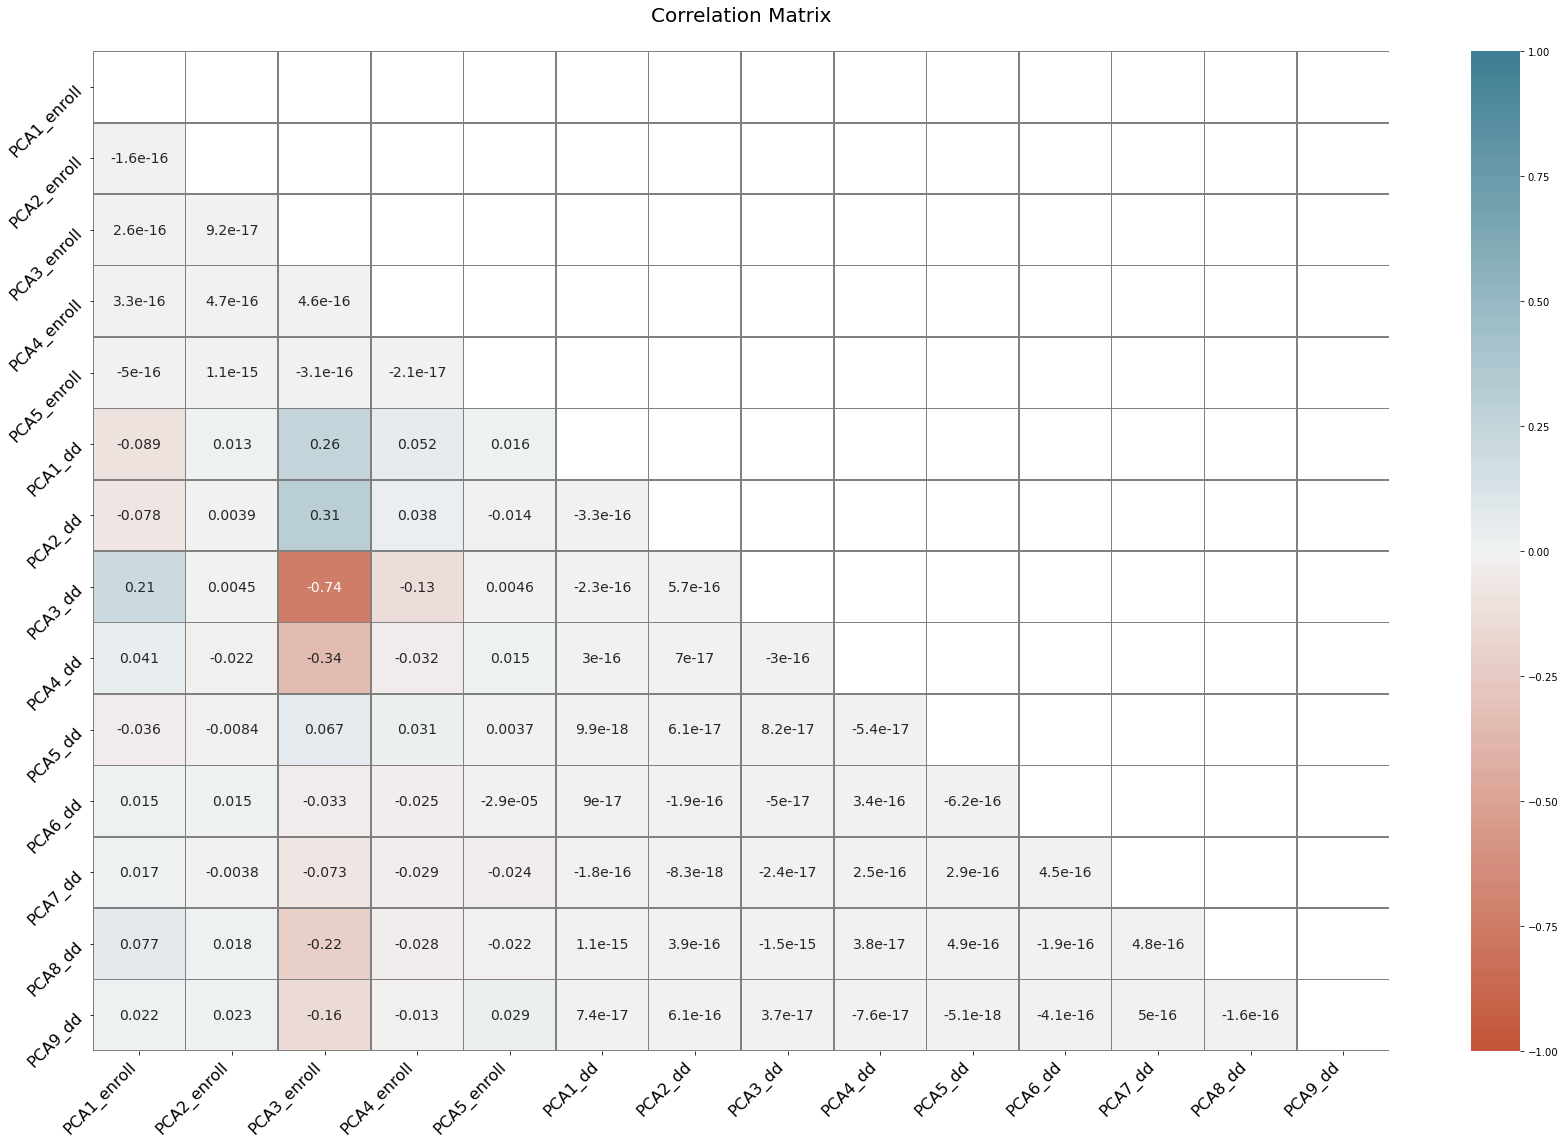

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(24, 16))
cormat = X_train_PCA2.corr()
sns.heatmap(cormat,
            cmap=sns.diverging_palette(20, 220, n=200),
            annot = True,
            annot_kws={"size": 14},
            linewidths=0.5,
            vmin=-1, vmax=1, center= 0,
            linecolor='grey',
            mask=np.triu(cormat),
            ax=ax)
ax.set_title('Correlation Matrix', fontsize=20, pad=30)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize = 16)
ax.set_yticklabels(ax.get_yticklabels(),rotation=45, fontsize = 16)
fig.tight_layout()
plt.show()

**Scaling activity**

In [71]:
rc = RobustScaler()
rc.fit(X_train_PCA2)

X_train_scaled = rc.transform(X_train_PCA2)
X_valid_scaled = rc.transform(X_valid_PCA2)
X_test_scaled = rc.transform(X_test_PCA2)

In [72]:
##We started with this dimension
X_train.shape, X_valid.shape, X_test.shape

((4296, 23), (921, 23), (921, 23))

In [73]:
##We are going with this dimension before modelling phase
X_train_PCA2.shape, X_valid_PCA2.shape, X_test_PCA2.shape

((4296, 14), (921, 14), (921, 14))

**Remove constant, quasi-constant and duplicate features**

In [74]:
# check if any numerical features from the 50 have any constant variance, i.e. standard deviation as zero

store = []
for i in range(len(X_train_PCA2.columns)):
    if X_train_PCA2[X_train_PCA2.columns[i]].dtype != 'object':
        varname = X_train_PCA2.columns[i]
        store.append(varname)

constant_features = [x for x in store if X_train_PCA2[x].std() == 0]

X_train_PCA2.drop(labels=constant_features, axis=1, inplace=True)
X_valid_PCA2.drop(labels=constant_features, axis=1, inplace=True)
X_test_PCA2.drop(labels=constant_features, axis=1, inplace=True)

print(X_train_PCA2.shape, X_valid_PCA2.shape, X_test_PCA2.shape)

(4296, 14) (921, 14) (921, 14)


In [75]:
del store

In [76]:
# create an empty list
quasi_constant_feat = []

# iterate over every attributes in the train set including numerical and object variables
for k in X_train_PCA2.columns:
    # find the dominant value, that is the value that is shared by most observations
    predominant = (X_train_PCA2[k].value_counts() / np.float(
        len(X_train_PCA2))).sort_values(ascending=False).values[0]

    # evaluate the dominant feature: do more than 99% of the observations show 1 single value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(k)

len(quasi_constant_feat)

0

In [77]:
quasi_constant_feat

[]

In [78]:
X_train_PCA2.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_valid_PCA2.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test_PCA2.drop(labels=quasi_constant_feat, axis=1, inplace=True)

print(X_train_PCA2.shape, X_valid_PCA2.shape, X_test_PCA2.shape)

(4296, 14) (921, 14) (921, 14)


In [79]:
##Check if we have features that despite having different names, are identical.
# check for duplicated features in the training set:

# create an empty dictionary, where we will store 
# the groups of duplicates
duplicated_feat_pairs = {}

# create an empty list to collect features
# that were found to be duplicated
_duplicated_feat = []


# iterate over every feature in our dataset:
for i in range(0, len(X_train_PCA2.columns)):
    
    # this bit helps me understand where the loop is at:
    if i % 10 == 0:  
        print(i)
    
    # choose 1 feature:
    feat_1 = X_train_PCA2.columns[i]
    
    # check if this feature has already been identified
    # as a duplicate of another one. If it was, it should be stored in
    # our _duplicated_feat list.
    
    # If this feature was already identified as a duplicate, we skip it, if
    # it has not yet been identified as a duplicate, then we proceed:
    if feat_1 not in _duplicated_feat:
    
        # create an empty list as an entry for this feature in the dictionary:
        duplicated_feat_pairs[feat_1] = []

        # now, iterate over the remaining features of the dataset:
        for feat_2 in X_train_PCA2.columns[i + 1:]:

            # check if this second feature is identical to the first one
            if X_train_PCA2[feat_1].equals(X_train_PCA2[feat_2]):

                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)
                
                # and append it to our monitor list for duplicated variables
                _duplicated_feat.append(feat_2)
                
                # done!

0
10


In [80]:
## If length is positive then we do have some duplicated features
len(_duplicated_feat)
# duplicated_feat_pairs

0

**Feature importance using Random Forest**

In [81]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
sel_ = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=20))

sel_.fit(X_train_PCA2, y_train.values.flatten())

selected_attr = X_train_PCA2.columns[(sel_.get_support())]

len(selected_attr)

2

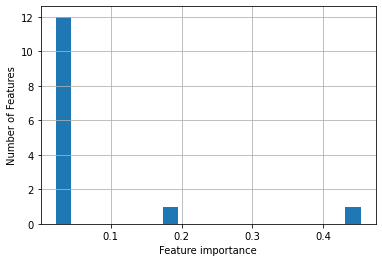

In [83]:
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

In [84]:
##Somehow sns.set(font_scale = 5) is giving clear images of feature importance but resettig other plot options
def plotImp(model, X , num = 20, text="ABC"):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title(text)
    plt.tight_layout()
    plt.show()

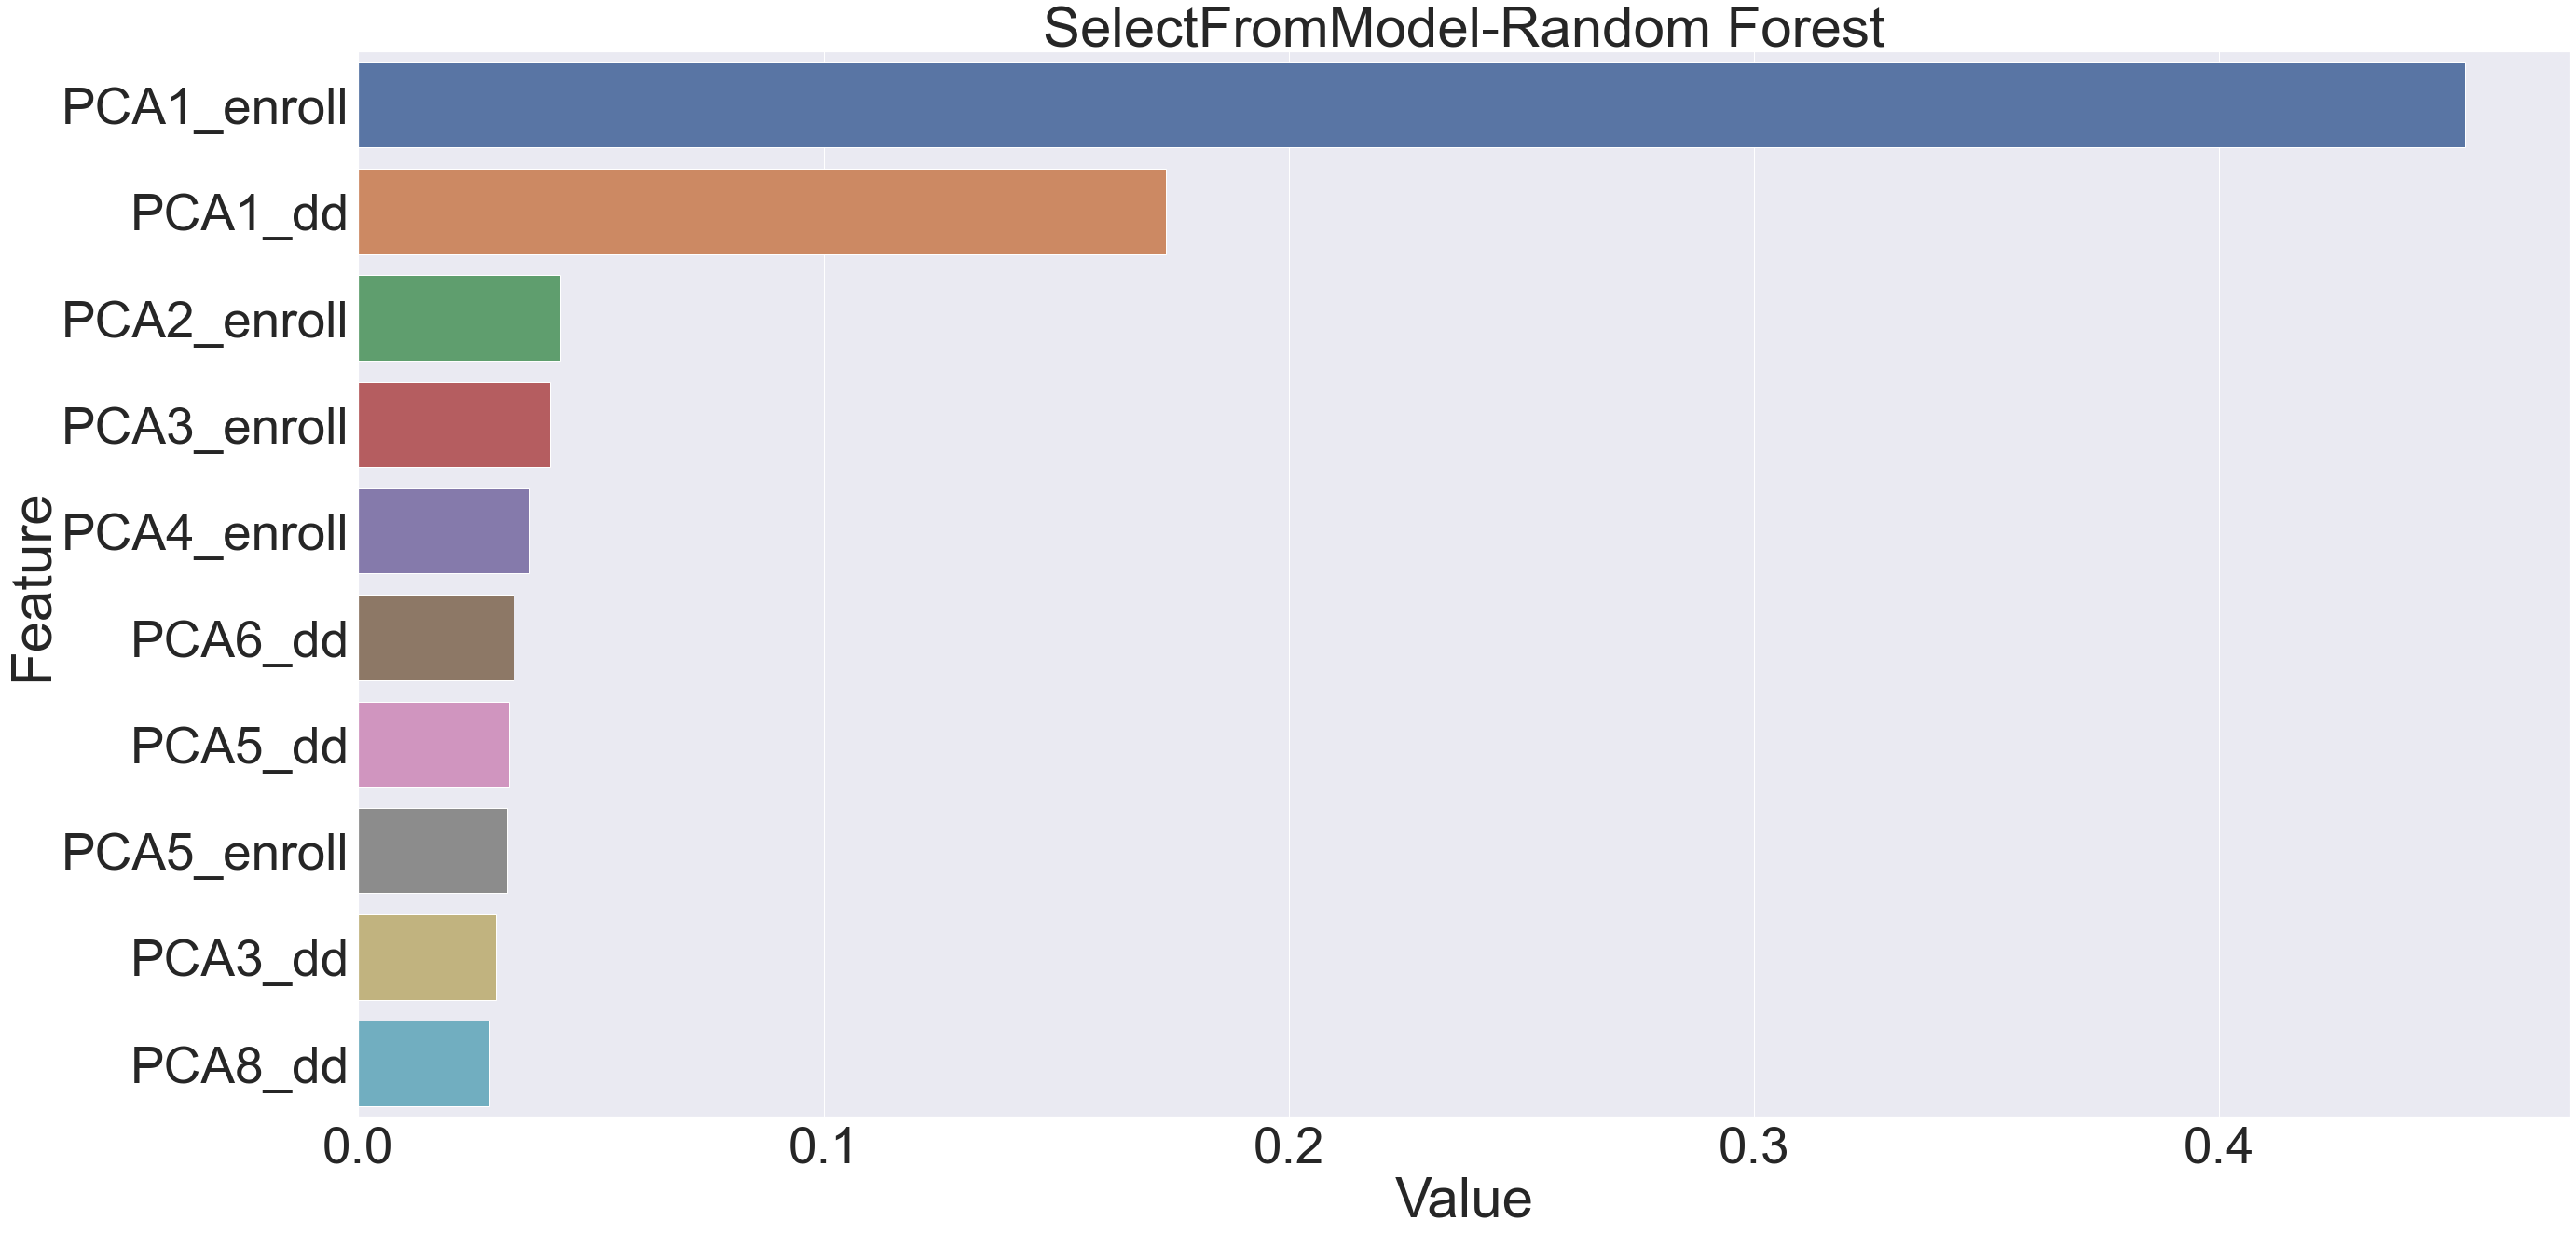

In [85]:
plotImp(sel_.estimator_, X_train_PCA2, num=10, text='SelectFromModel-Random Forest')

In [86]:
print('total features: {}'.format((X_train_PCA2.shape[1])))

print('selected features: {}'.format(len(selected_attr)))

print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

total features: 14
selected features: 2
features with importance greater than the mean importance of all features: 2


In [87]:
selected_attr

Index(['PCA1_enroll', 'PCA1_dd'], dtype='object')

**Feature importance using Gradient Boosting**

In [88]:
from sklearn.ensemble import GradientBoostingRegressor

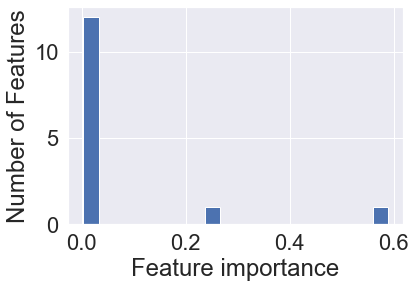

total features: 14
selected features: 2
features with importance greater than the mean importance of all features: 2


In [89]:
sel_ = SelectFromModel(GradientBoostingRegressor(n_estimators=100, random_state=20))

sel_.fit(X_train_PCA2, y_train.values.flatten())

selected_attr = X_train_PCA2.columns[(sel_.get_support())]

len(selected_attr)
sns.set(font_scale = 2)
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

print('total features: {}'.format((X_train_PCA2.shape[1])))

print('selected features: {}'.format(len(selected_attr)))

print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

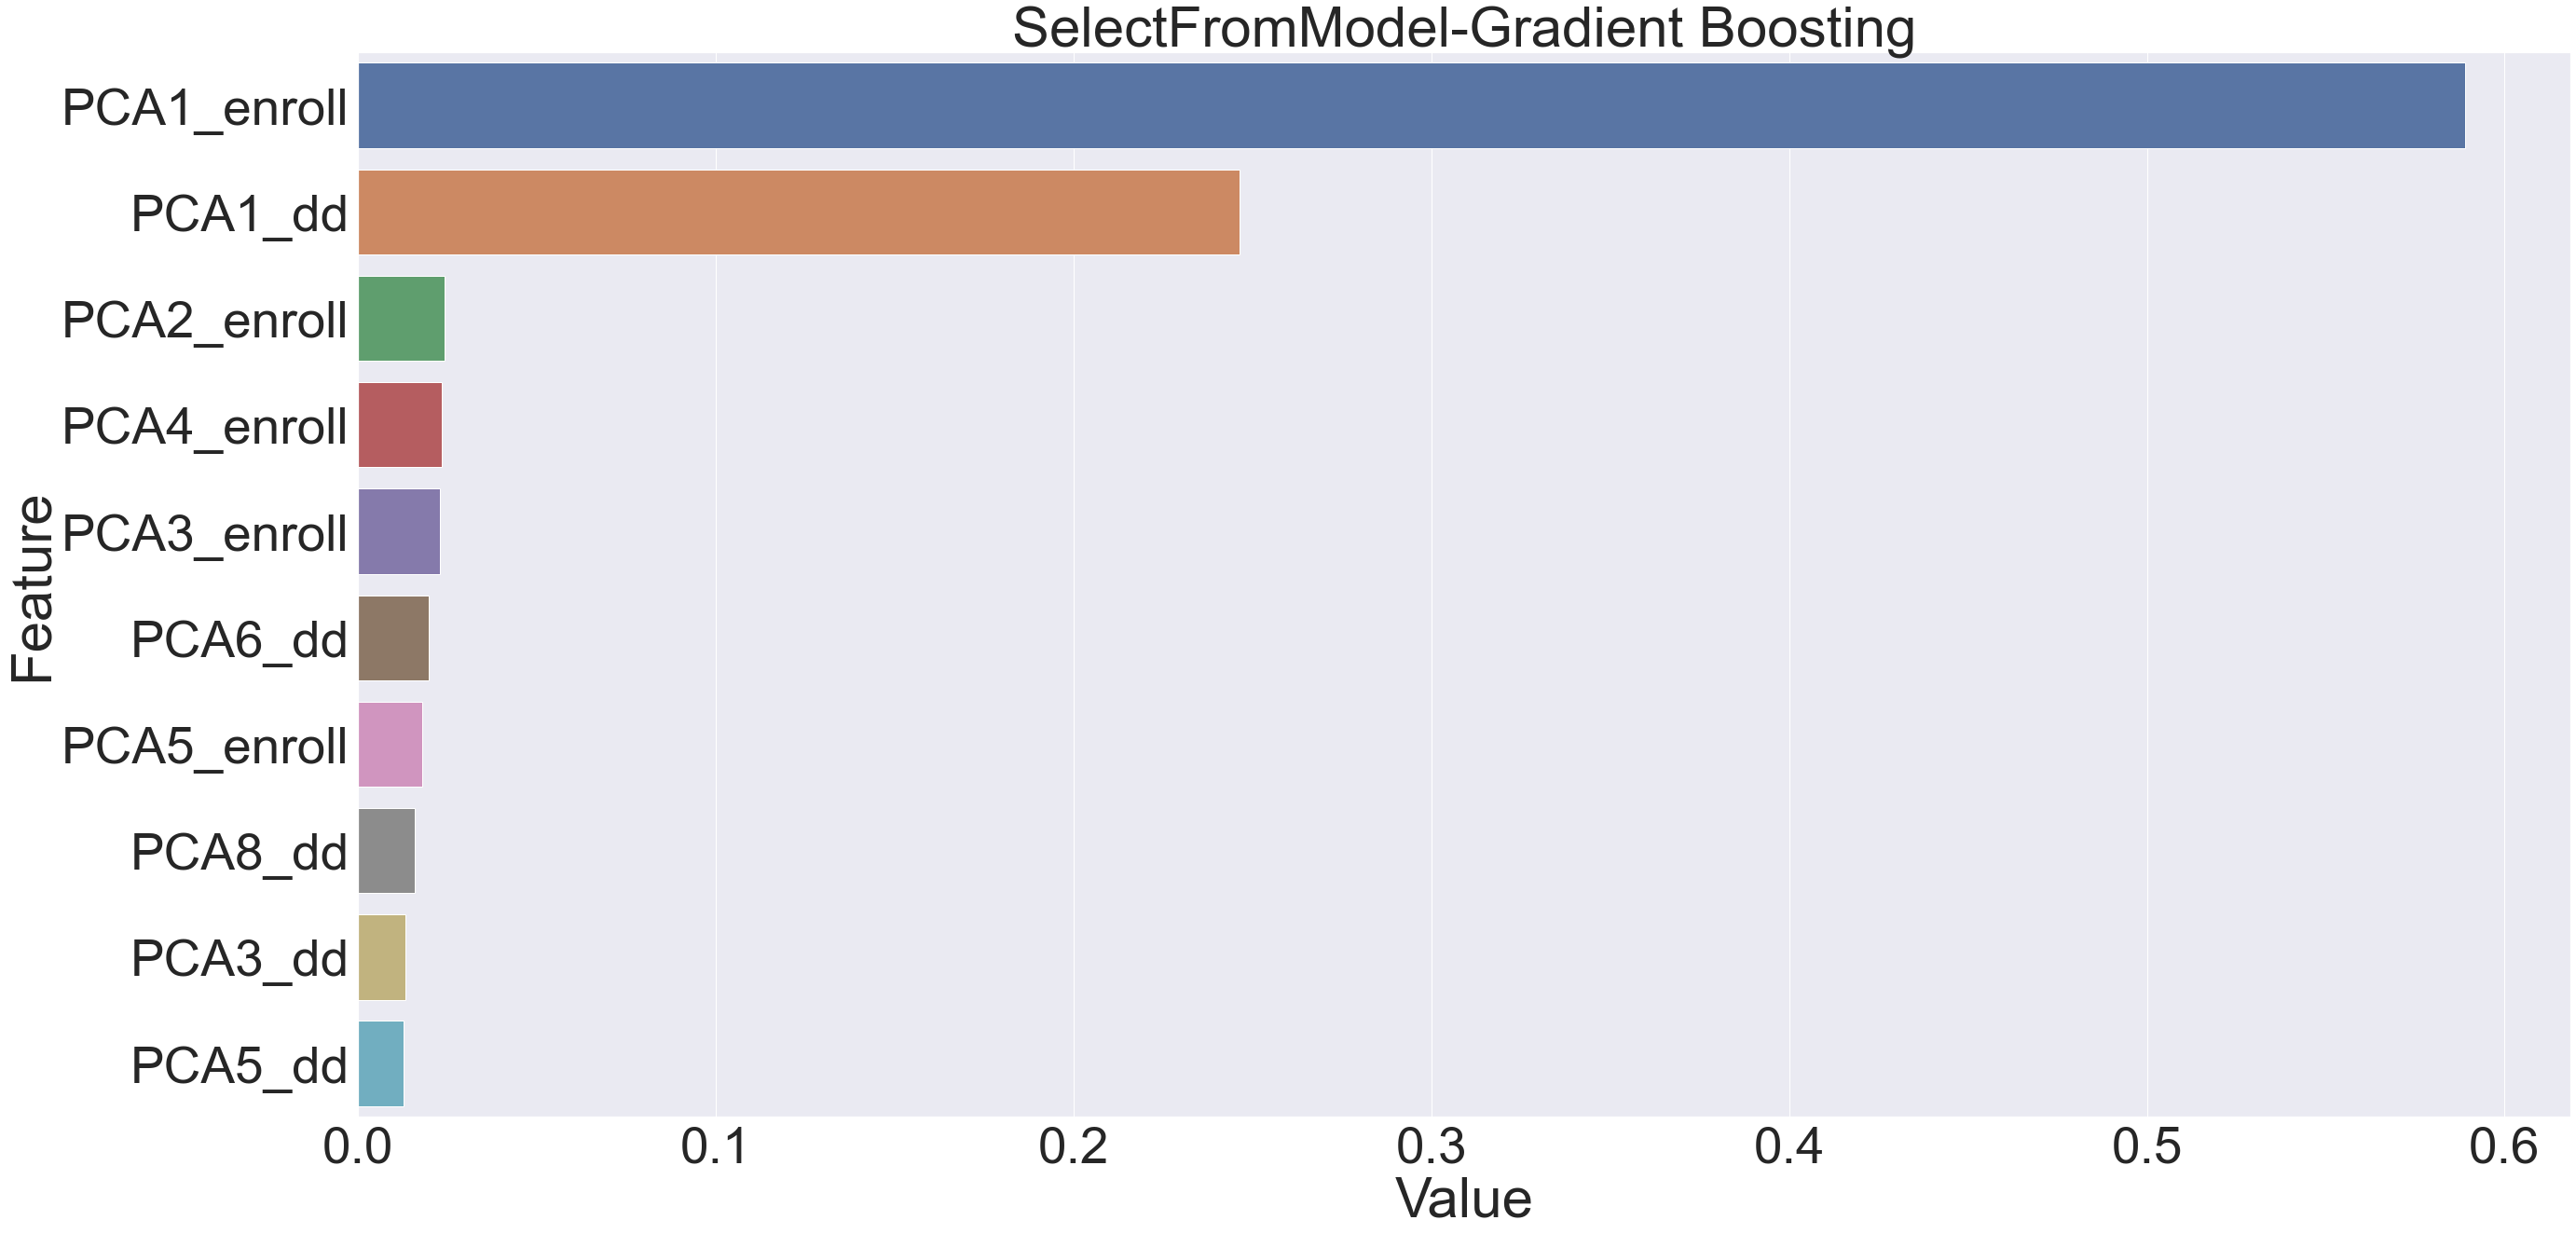

In [90]:
plotImp(sel_.estimator_, X_train_PCA2, num=10, text='SelectFromModel-Gradient Boosting')

In [91]:
selected_attr

Index(['PCA1_enroll', 'PCA1_dd'], dtype='object')

**Feature importance using Extreme Gradient Boosting**

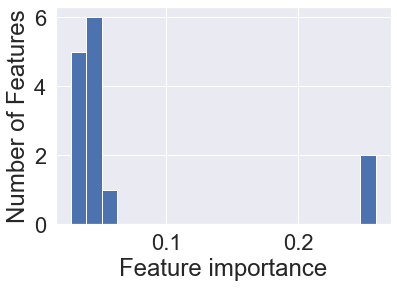

total features: 14
selected features: 2
features with importance greater than the mean importance of all features: 2


In [92]:
sel_ = SelectFromModel(xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=10))

sel_.fit(X_train_PCA2, y_train.values.flatten())

selected_attr = X_train_PCA2.columns[(sel_.get_support())]

len(selected_attr)
sns.set(font_scale = 2)
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

print('total features: {}'.format((X_train_PCA2.shape[1])))

print('selected features: {}'.format(len(selected_attr)))

print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

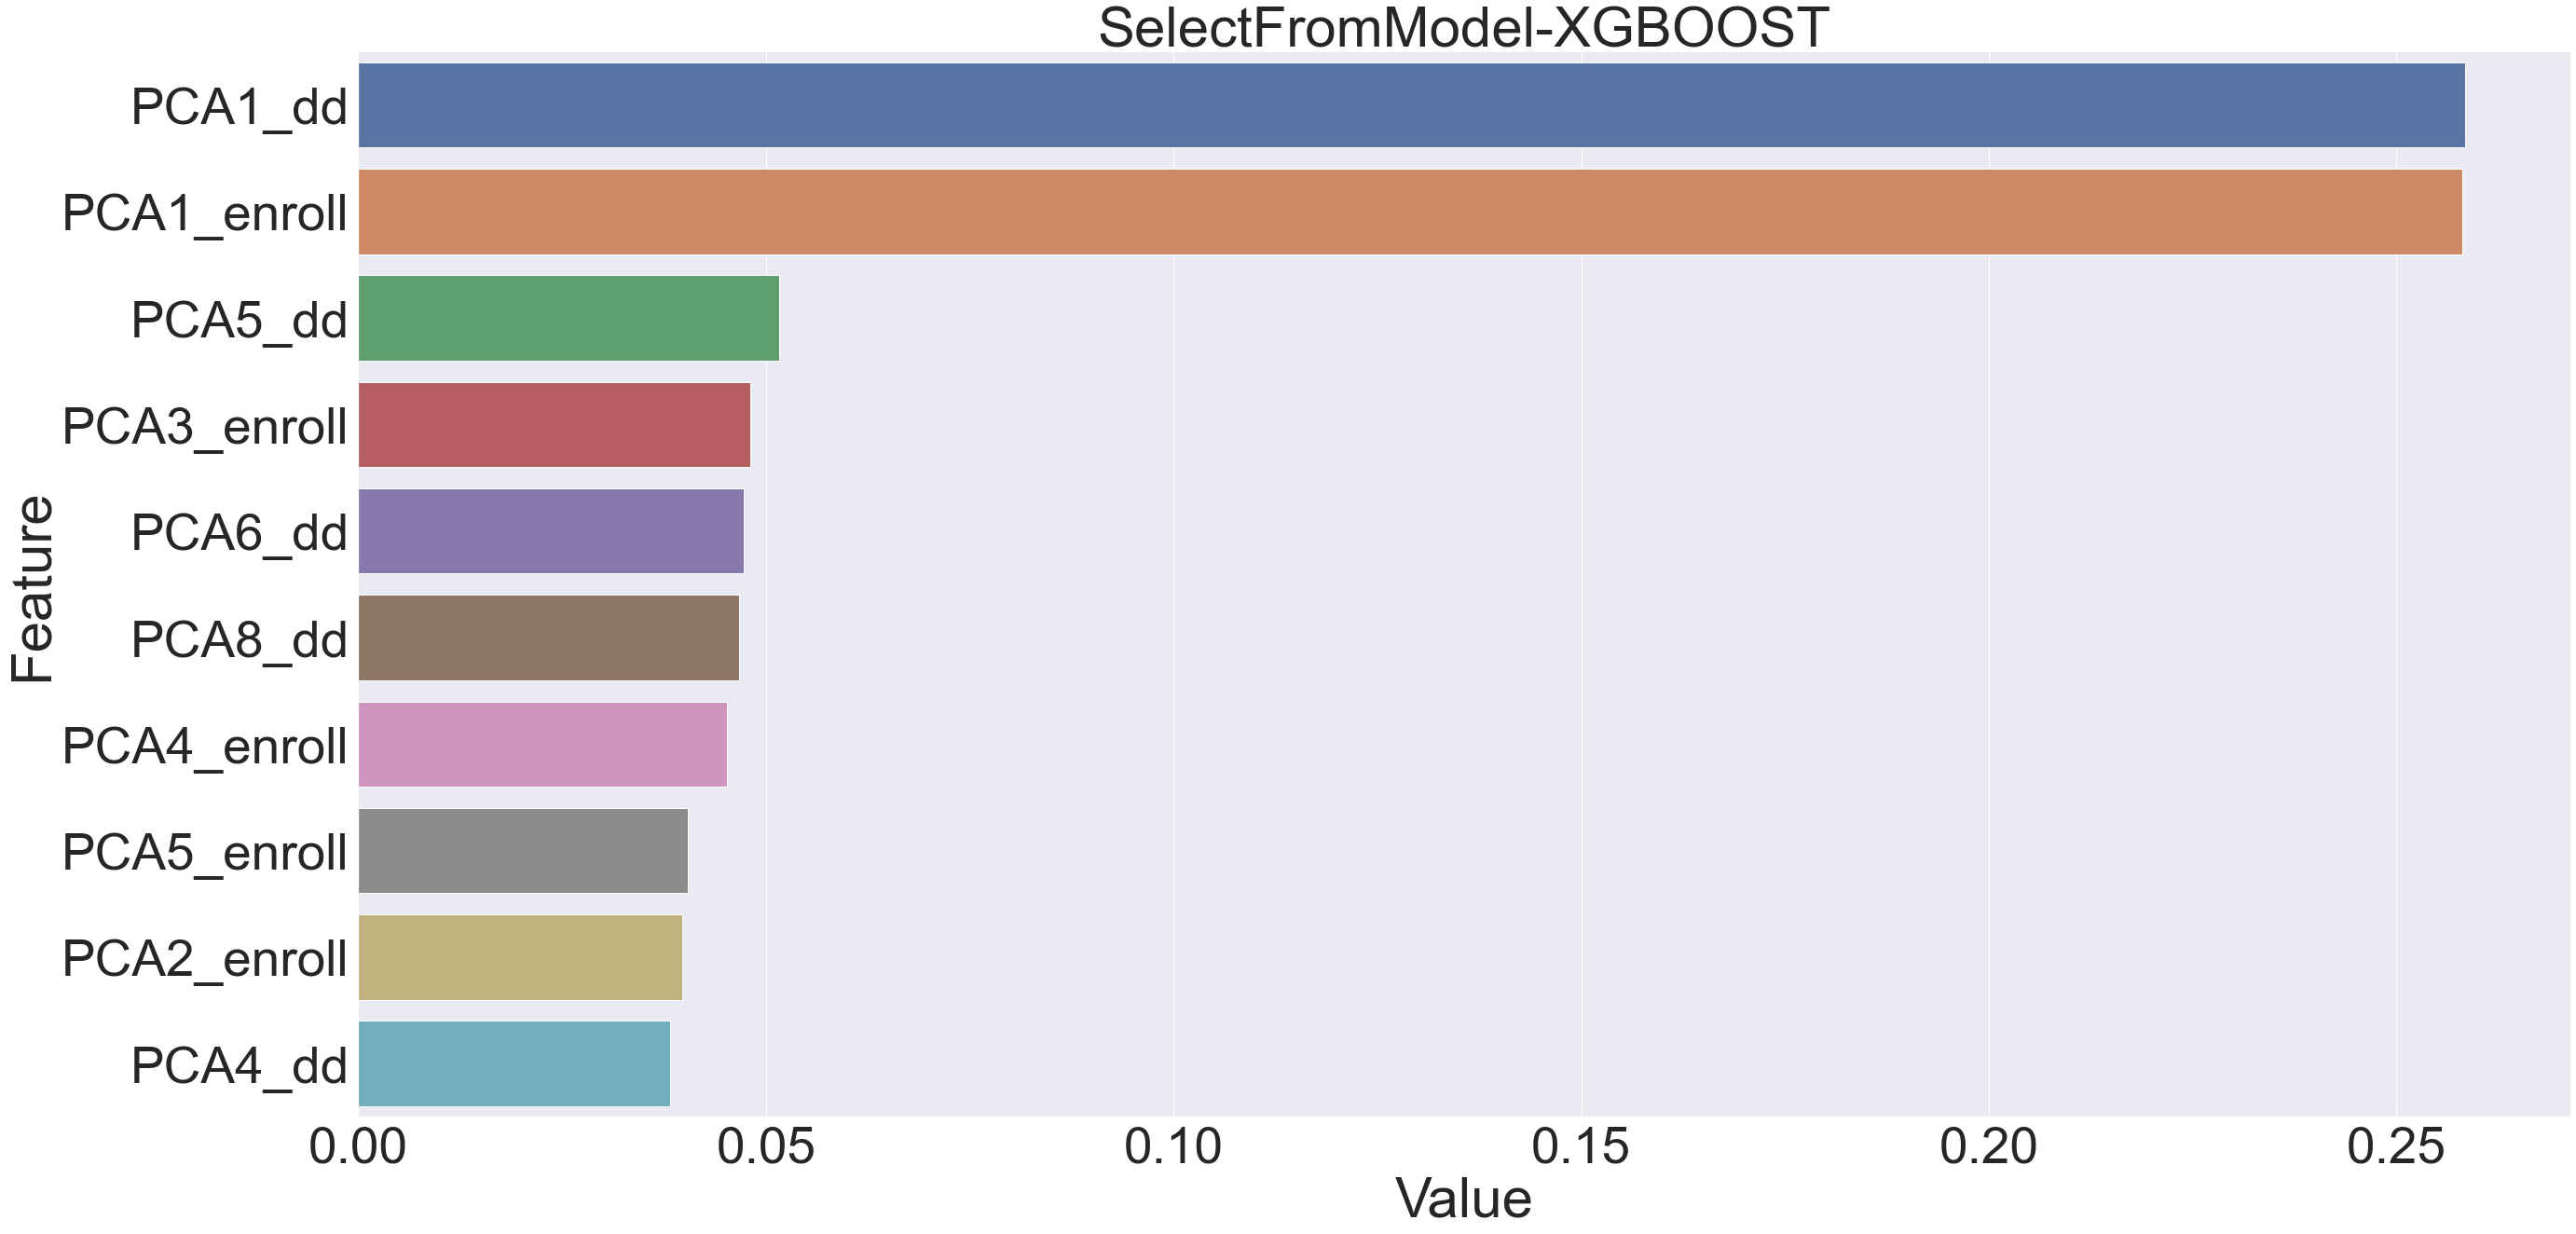

In [93]:
plotImp(sel_.estimator_, X_train_PCA2, num=10, text='SelectFromModel-XGBOOST')

In [94]:
selected_attr

Index(['PCA1_enroll', 'PCA1_dd'], dtype='object')

**Feature importance using Light GBM**

In [95]:
from lightgbm import LGBMRegressor

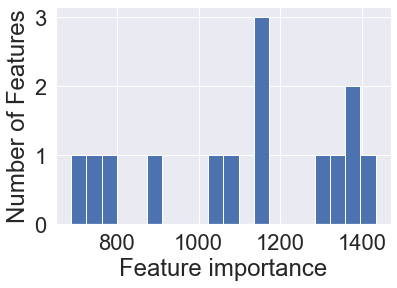

total features: 14
selected features: 8
features with importance greater than the mean importance of all features: 8


Index(['PCA1_enroll', 'PCA2_enroll', 'PCA3_enroll', 'PCA4_enroll',
       'PCA5_enroll', 'PCA1_dd', 'PCA4_dd', 'PCA6_dd'],
      dtype='object')

In [96]:
sel_ = SelectFromModel(
    LGBMRegressor(boosting_type='gbdt', n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                   reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40
                   ))

sel_.fit(X_train_PCA2, y_train.values.flatten())

selected_attr = X_train_PCA2.columns[(sel_.get_support())]

len(selected_attr)
sns.set(font_scale = 2)
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

print('total features: {}'.format((X_train_PCA2.shape[1])))

print('selected features: {}'.format(len(selected_attr)))

print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

selected_attr

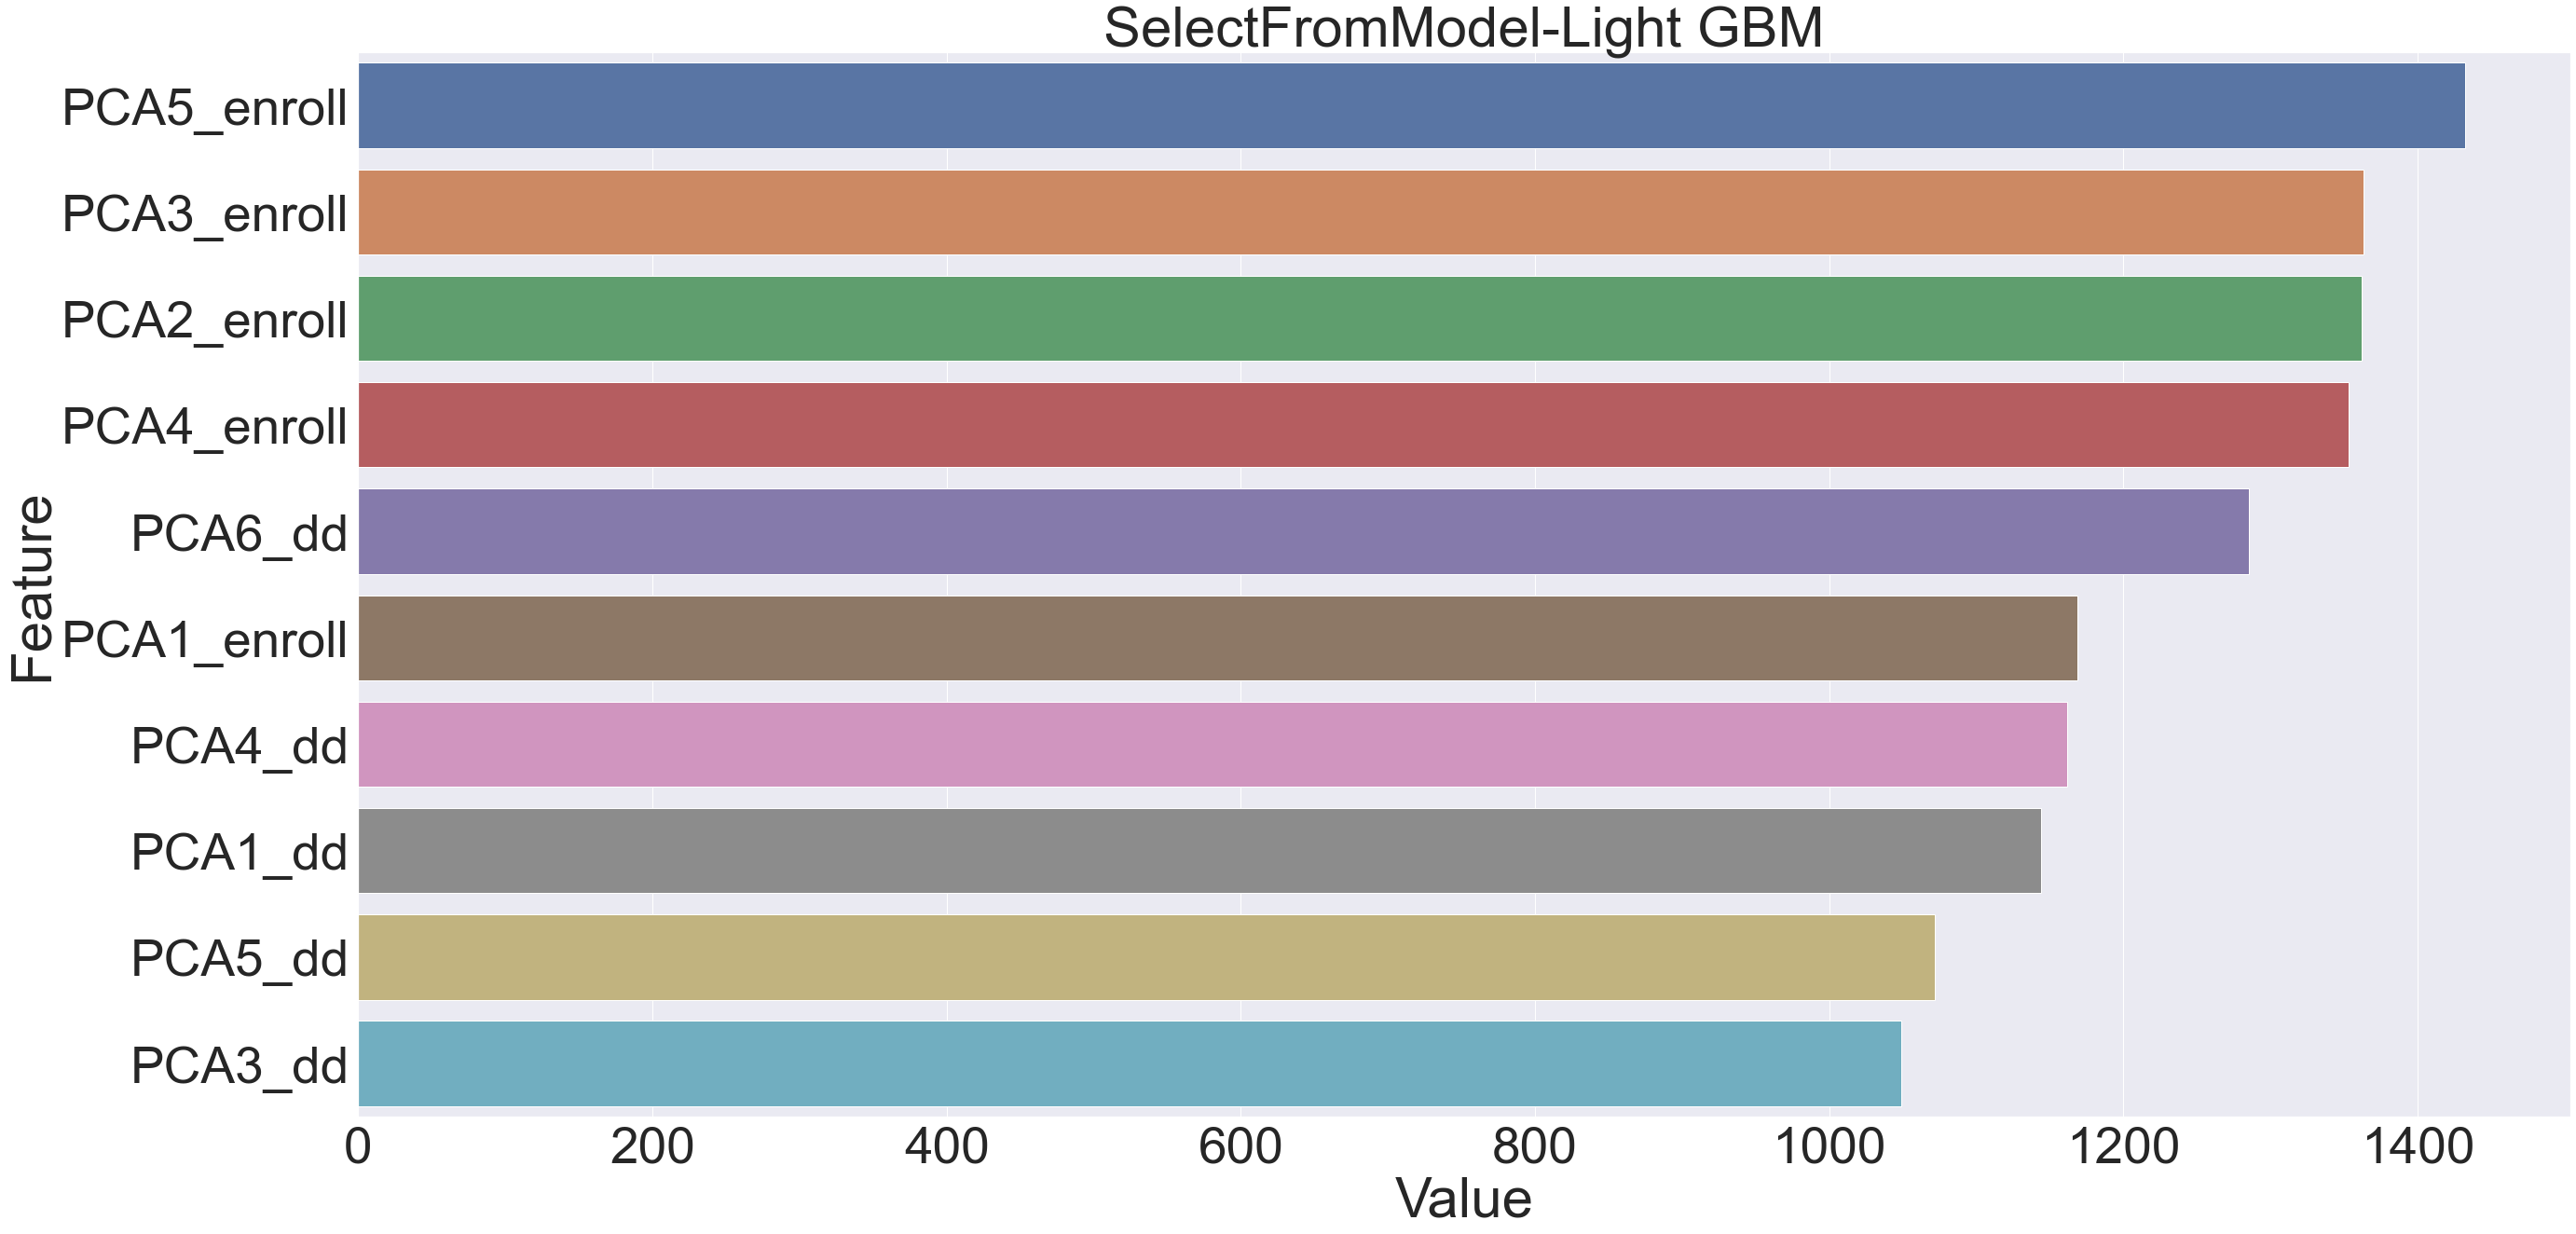

In [97]:
plotImp(sel_.estimator_, X_train_PCA2, num=10, text='SelectFromModel-Light GBM')

**RFECV using Light GBM**

In [98]:
sel_ = RFECV(LGBMRegressor(boosting_type='gbdt', n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                   reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40, random_state=10
                   ),
             min_features_to_select=10, step=5, scoring="neg_mean_squared_error")

sel_.fit(X_train_PCA2, y_train.values.flatten())

selected_attr = X_train_PCA2.columns[(sel_.get_support())]
len(selected_attr)

14

In [99]:
selected_attr

Index(['PCA1_enroll', 'PCA2_enroll', 'PCA3_enroll', 'PCA4_enroll',
       'PCA5_enroll', 'PCA1_dd', 'PCA2_dd', 'PCA3_dd', 'PCA4_dd', 'PCA5_dd',
       'PCA6_dd', 'PCA7_dd', 'PCA8_dd', 'PCA9_dd'],
      dtype='object')

**Light GBM**

In [100]:
import time

from sklearn.model_selection import KFold

In [101]:
##First phase
# estimator = LGBMRegressor(boosting_type ="gbdt",
#                            objective = "regression",
#                            random_state=10,
#                            min_split_gain=0.01,
#                            importance_type = "gain",
#                            n_jobs=-1)

# def lgb_parameter(X_data, y_data):
#     learning_rate = np.arange(0.01,1,0.05)
#     n_estimators = [int(x) for x in np.linspace(100, 1000, 200)]
#     max_depth = [int(x) for x in np.linspace(5, 55, 11)]
#     colsample_bytree = [0.3, 0.5, 0.8, 1.0]
#     reg_alpha = [0, 0.5, 1]
#     reg_lambda = [1, 1.5, 2, 3, 4.5]
#     num_leaves = np.linspace(10, 200, 10, dtype=np.int32)
#     param_grid = {'learning_rate': learning_rate,
#                   'n_estimators': n_estimators,
#                   'max_depth': max_depth,
#                   'colsample_bytree' : colsample_bytree,
#                   'reg_alpha' : reg_alpha,
#                   'reg_lambda' : reg_lambda,
#                   'num_boost_round' : [500], 
#                   'early_stopping_rounds' : [10],
#                   "num_leaves" : num_leaves}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=KFold(10, shuffle=True, random_state=123),
#                             scoring="neg_mean_squared_error", random_state=123, return_train_score=True, verbose=1,
#                             n_iter=50)
#     gs.fit(X_data, y_data, eval_set=[(X_valid_scaled, y_valid.values.flatten())])
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = lgb_parameter(X_train_scaled, y_train.values.flatten())
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

# Best parameters: {'reg_lambda': 1.5, 'reg_alpha': 0, 'num_leaves': 31, 'num_boost_round': 500, 'n_estimators': 109, 'max_depth': 30, 'learning_rate': 0.060000000000000005, 'early_stopping_rounds': 10, 'colsample_bytree': 0.5}
# Time consumed for training: 373.250 seconds

In [102]:
estimator1 = LGBMRegressor(boosting_type ="gbdt",
                           objective = "regression",
                           random_state=10,
                           min_split_gain=0.01,
                           importance_type = "gain",
                           n_jobs=-1, reg_alpha=0, reg_lambda=1.5,
                           num_leaves=31, n_estimators=109, max_depth=30, learning_rate=0.060000000000000005, colsample_bytree=0.5)

In [103]:
##PLot feature importance
def plotImp(model, X , num = 20, text="ABC"):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title(text)
    plt.tight_layout()
    plt.show()

In [104]:
estimator1.fit(X_train_scaled, y_train.values.flatten())

LGBMRegressor(colsample_bytree=0.5, importance_type='gain',
              learning_rate=0.060000000000000005, max_depth=30,
              min_split_gain=0.01, n_estimators=109, objective='regression',
              random_state=10, reg_alpha=0, reg_lambda=1.5)

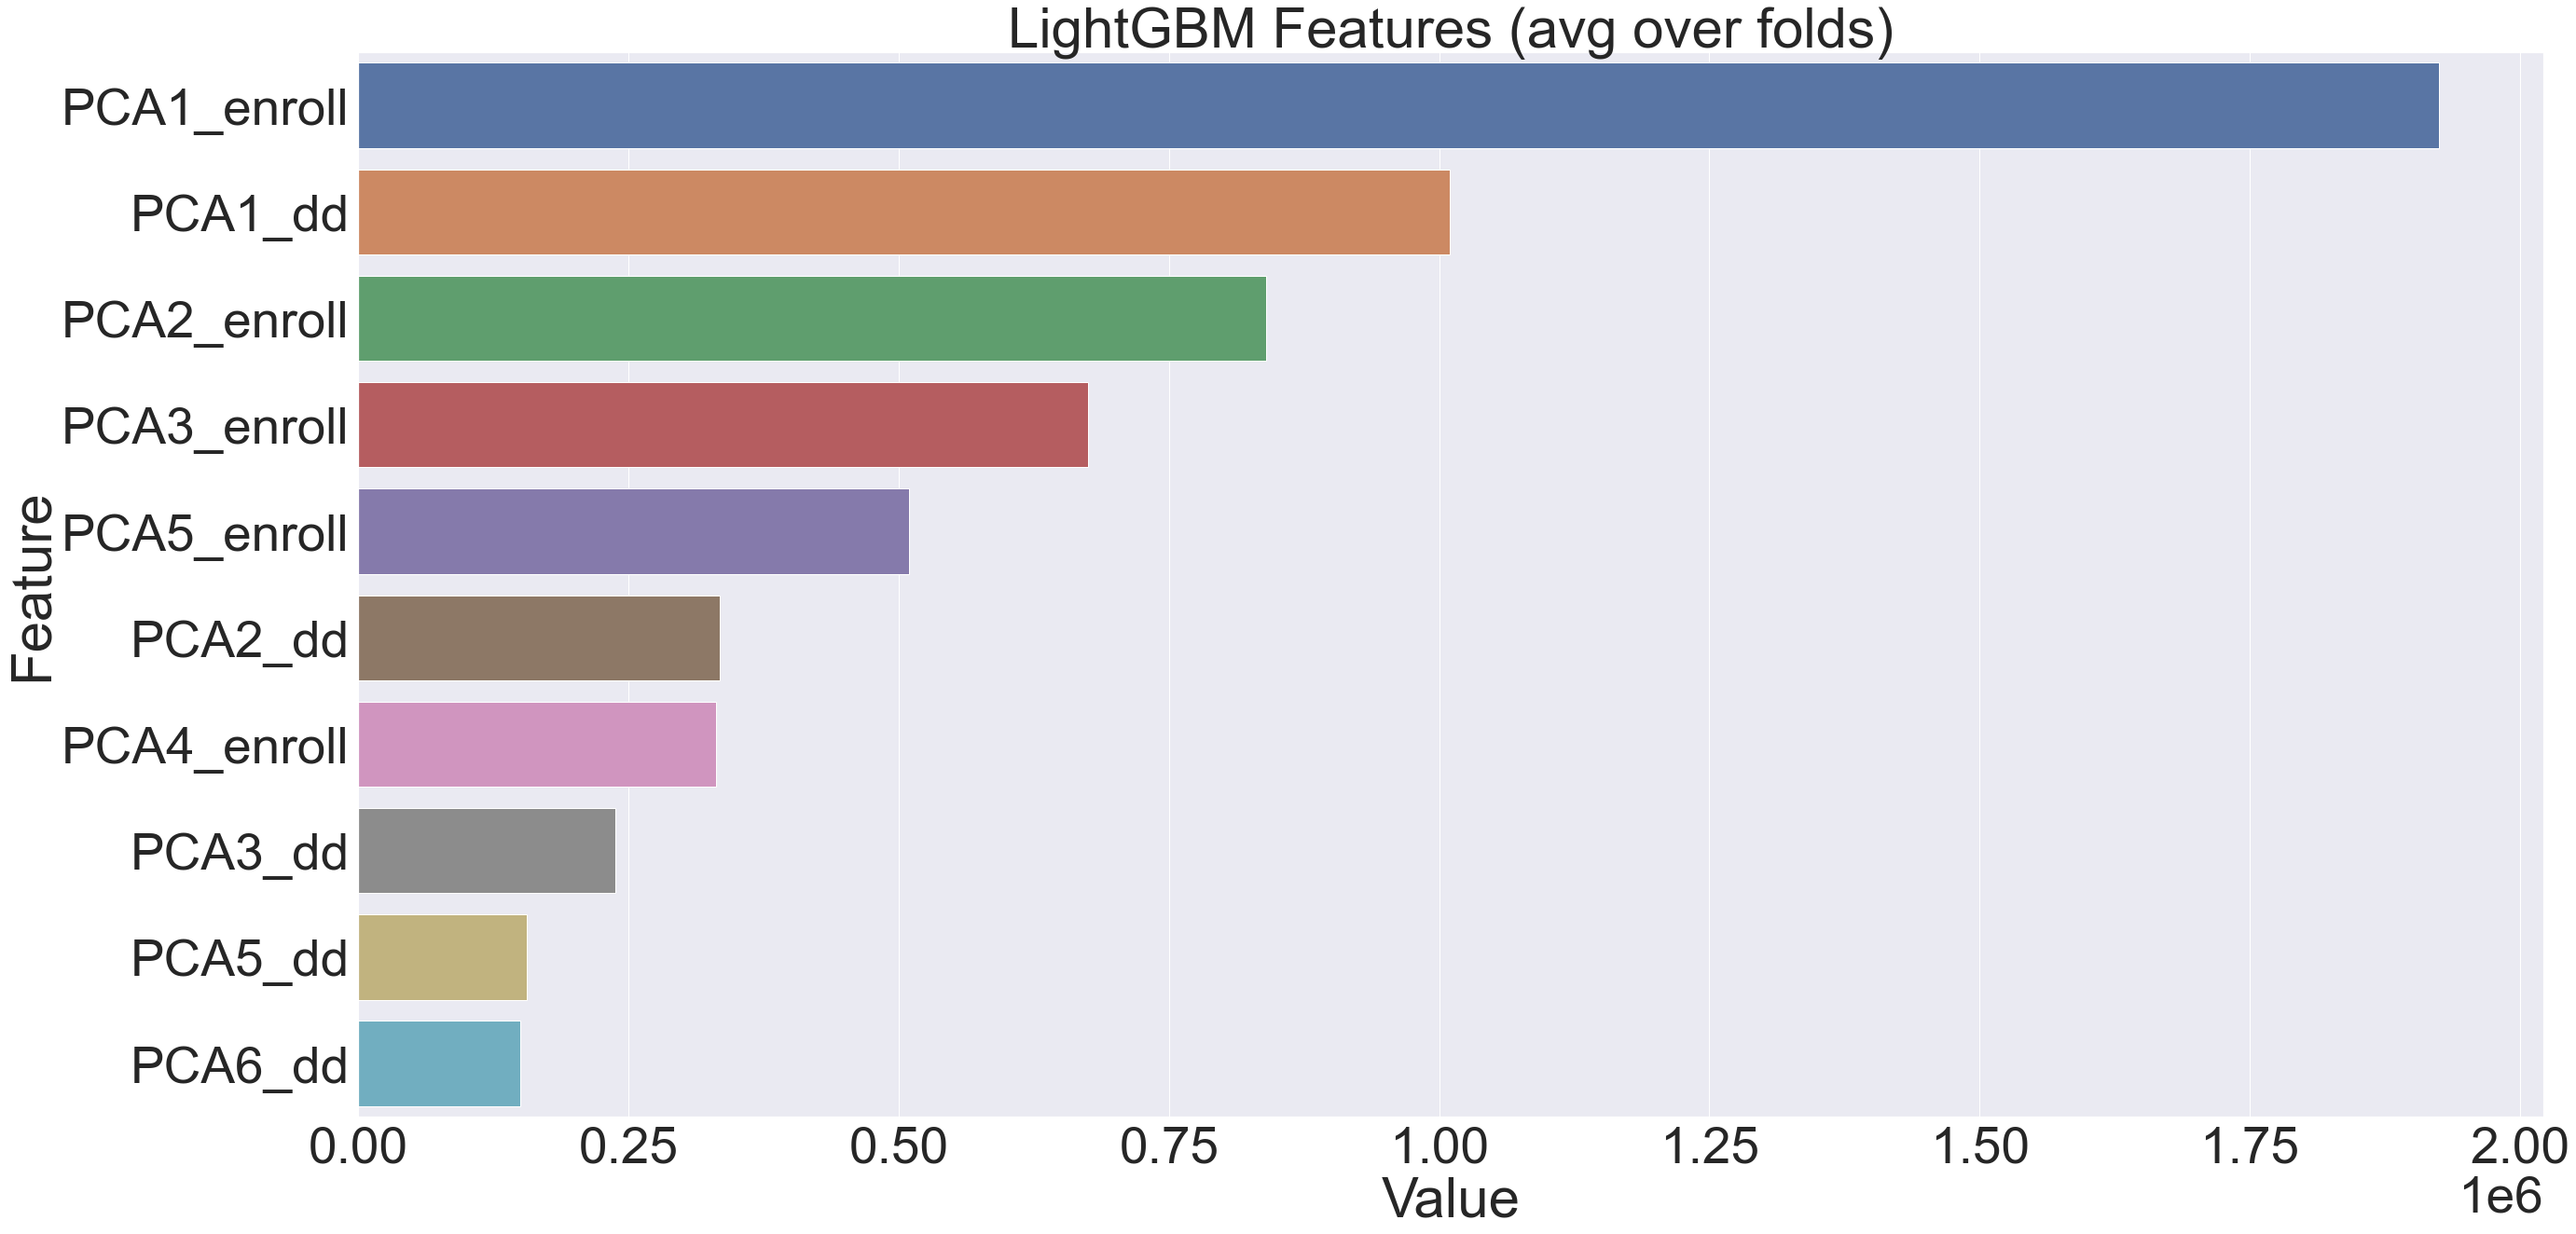

In [105]:
plotImp(estimator1, X_train_PCA2, num=10, text='LightGBM Features (avg over folds)')

In [106]:
##Predict train set
train_predictions_lgbm = estimator1.predict(X_train_scaled)
##Predict validation set
valid_predictions_lgbm = estimator1.predict(X_valid_scaled)
##Predict test set
test_predictions_lgbm = estimator1.predict(X_test_scaled)

In [107]:
from sklearn.metrics import mean_squared_error

In [108]:
print(f"The RMSE for training set is {np.round(np.sqrt(mean_squared_error(y_train, train_predictions_lgbm)),3)}")
print(f"The RMSE for validation set is {np.round(np.sqrt(mean_squared_error(y_valid, valid_predictions_lgbm)),3)}")
print(f"The RMSE for test set is {np.round(np.sqrt(mean_squared_error(y_test, test_predictions_lgbm)),3)}")

The RMSE for training set is 6.218
The RMSE for validation set is 8.477
The RMSE for test set is 8.288


**Catboost**

In [109]:
import catboost as cb

In [110]:
# estimator = cb.CatBoostRegressor(random_state=190, loss_function="RMSE")

# def catboost_parameter(X_data, y_data):
#     learning_rate = np.arange(0.01,1,0.05)
#     n_estimators = [int(x) for x in np.linspace(100, 1000, 200)]
#     depth = [3,1,2,6,4,5,7,8,9,10]
#     colsample_bylevel = np.arange(0.3, 0.8, 0.1)
#     l2_leaf_reg = [3,1,5,10,100]
#     border_count = [32,5,10,20,50,100,200]
    
#     param_grid = {'learning_rate': learning_rate,
#                   'n_estimators': n_estimators,
#                   'depth': depth,
#                   'colsample_bylevel' : colsample_bylevel,
#                   'l2_leaf_reg' : l2_leaf_reg,
#                   'border_count' : border_count,
#                   'early_stopping_rounds' : [10]}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=KFold(10, shuffle=True, random_state=123),
#                             scoring="neg_mean_squared_error", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data, eval_set=[(X_valid_scaled, y_valid.values.flatten())])
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = catboost_parameter(X_train_scaled, y_train.values.flatten())
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

# Best parameters: {'n_estimators': 606, 'learning_rate': 0.11, 'l2_leaf_reg': 5, 'early_stopping_rounds': 10, 'depth': 5, 'colsample_bylevel': 0.4, 'border_count': 100}
# Time consumed for training: 522.420 seconds

In [111]:
estimator2 = cb.CatBoostRegressor(random_state=190, loss_function="RMSE",
                                  n_estimators=606, learning_rate=0.11, l2_leaf_reg=5,
                                  depth=5, colsample_bylevel=0.40, border_count=100)

In [112]:
estimator2.fit(X_train_scaled, y_train.values.flatten())

0:	learn: 14.1410687	total: 52.1ms	remaining: 31.5s
1:	learn: 13.6233942	total: 54.6ms	remaining: 16.5s
2:	learn: 13.1723991	total: 57.2ms	remaining: 11.5s
3:	learn: 12.7395728	total: 59.5ms	remaining: 8.96s
4:	learn: 12.3177398	total: 62.2ms	remaining: 7.47s
5:	learn: 12.0190291	total: 64.4ms	remaining: 6.44s
6:	learn: 11.7239879	total: 67ms	remaining: 5.73s
7:	learn: 11.5338713	total: 69.1ms	remaining: 5.16s
8:	learn: 11.2766009	total: 71.7ms	remaining: 4.75s
9:	learn: 11.0971859	total: 75.4ms	remaining: 4.5s
10:	learn: 10.9360711	total: 78.2ms	remaining: 4.23s
11:	learn: 10.7896929	total: 80.8ms	remaining: 4s
12:	learn: 10.6614866	total: 83.2ms	remaining: 3.79s
13:	learn: 10.5607907	total: 86.2ms	remaining: 3.64s
14:	learn: 10.4104312	total: 88.9ms	remaining: 3.5s
15:	learn: 10.3129972	total: 91.2ms	remaining: 3.36s
16:	learn: 10.2655528	total: 93.8ms	remaining: 3.25s
17:	learn: 10.1777322	total: 97.8ms	remaining: 3.19s
18:	learn: 10.1088040	total: 100ms	remaining: 3.09s
19:	learn: 

184:	learn: 7.1638889	total: 380ms	remaining: 866ms
185:	learn: 7.1576227	total: 382ms	remaining: 863ms
186:	learn: 7.1465364	total: 384ms	remaining: 860ms
187:	learn: 7.1333169	total: 386ms	remaining: 858ms
188:	learn: 7.1255062	total: 388ms	remaining: 855ms
189:	learn: 7.1168672	total: 390ms	remaining: 853ms
190:	learn: 7.1109488	total: 392ms	remaining: 851ms
191:	learn: 7.1058683	total: 394ms	remaining: 849ms
192:	learn: 7.0991923	total: 396ms	remaining: 847ms
193:	learn: 7.0853335	total: 398ms	remaining: 844ms
194:	learn: 7.0760636	total: 404ms	remaining: 851ms
195:	learn: 7.0699094	total: 405ms	remaining: 848ms
196:	learn: 7.0654328	total: 407ms	remaining: 846ms
197:	learn: 7.0582657	total: 409ms	remaining: 843ms
198:	learn: 7.0536152	total: 411ms	remaining: 840ms
199:	learn: 7.0478784	total: 412ms	remaining: 836ms
200:	learn: 7.0405251	total: 414ms	remaining: 834ms
201:	learn: 7.0332464	total: 416ms	remaining: 832ms
202:	learn: 7.0317418	total: 418ms	remaining: 830ms
203:	learn: 

355:	learn: 6.1377259	total: 700ms	remaining: 492ms
356:	learn: 6.1341998	total: 702ms	remaining: 489ms
357:	learn: 6.1307108	total: 704ms	remaining: 487ms
358:	learn: 6.1219943	total: 705ms	remaining: 485ms
359:	learn: 6.1174878	total: 707ms	remaining: 483ms
360:	learn: 6.1106763	total: 709ms	remaining: 481ms
361:	learn: 6.1047521	total: 711ms	remaining: 479ms
362:	learn: 6.0988490	total: 712ms	remaining: 477ms
363:	learn: 6.0906214	total: 714ms	remaining: 475ms
364:	learn: 6.0861547	total: 716ms	remaining: 473ms
365:	learn: 6.0830309	total: 717ms	remaining: 470ms
366:	learn: 6.0793326	total: 719ms	remaining: 468ms
367:	learn: 6.0762967	total: 720ms	remaining: 466ms
368:	learn: 6.0732883	total: 722ms	remaining: 464ms
369:	learn: 6.0683643	total: 724ms	remaining: 462ms
370:	learn: 6.0643379	total: 725ms	remaining: 460ms
371:	learn: 6.0608142	total: 728ms	remaining: 458ms
372:	learn: 6.0564189	total: 731ms	remaining: 457ms
373:	learn: 6.0505866	total: 733ms	remaining: 455ms
374:	learn: 

540:	learn: 5.4023384	total: 1.02s	remaining: 123ms
541:	learn: 5.3980159	total: 1.03s	remaining: 121ms
542:	learn: 5.3956217	total: 1.03s	remaining: 119ms
543:	learn: 5.3921974	total: 1.03s	remaining: 117ms
544:	learn: 5.3865815	total: 1.03s	remaining: 115ms
545:	learn: 5.3832827	total: 1.03s	remaining: 114ms
546:	learn: 5.3788792	total: 1.03s	remaining: 112ms
547:	learn: 5.3766314	total: 1.04s	remaining: 110ms
548:	learn: 5.3725278	total: 1.04s	remaining: 108ms
549:	learn: 5.3698080	total: 1.04s	remaining: 106ms
550:	learn: 5.3671596	total: 1.04s	remaining: 104ms
551:	learn: 5.3637384	total: 1.04s	remaining: 102ms
552:	learn: 5.3591031	total: 1.04s	remaining: 100ms
553:	learn: 5.3569871	total: 1.05s	remaining: 98.2ms
554:	learn: 5.3548648	total: 1.05s	remaining: 96.3ms
555:	learn: 5.3521108	total: 1.05s	remaining: 94.4ms
556:	learn: 5.3488340	total: 1.05s	remaining: 92.5ms
557:	learn: 5.3450702	total: 1.05s	remaining: 90.6ms
558:	learn: 5.3413736	total: 1.05s	remaining: 88.7ms
559:	l

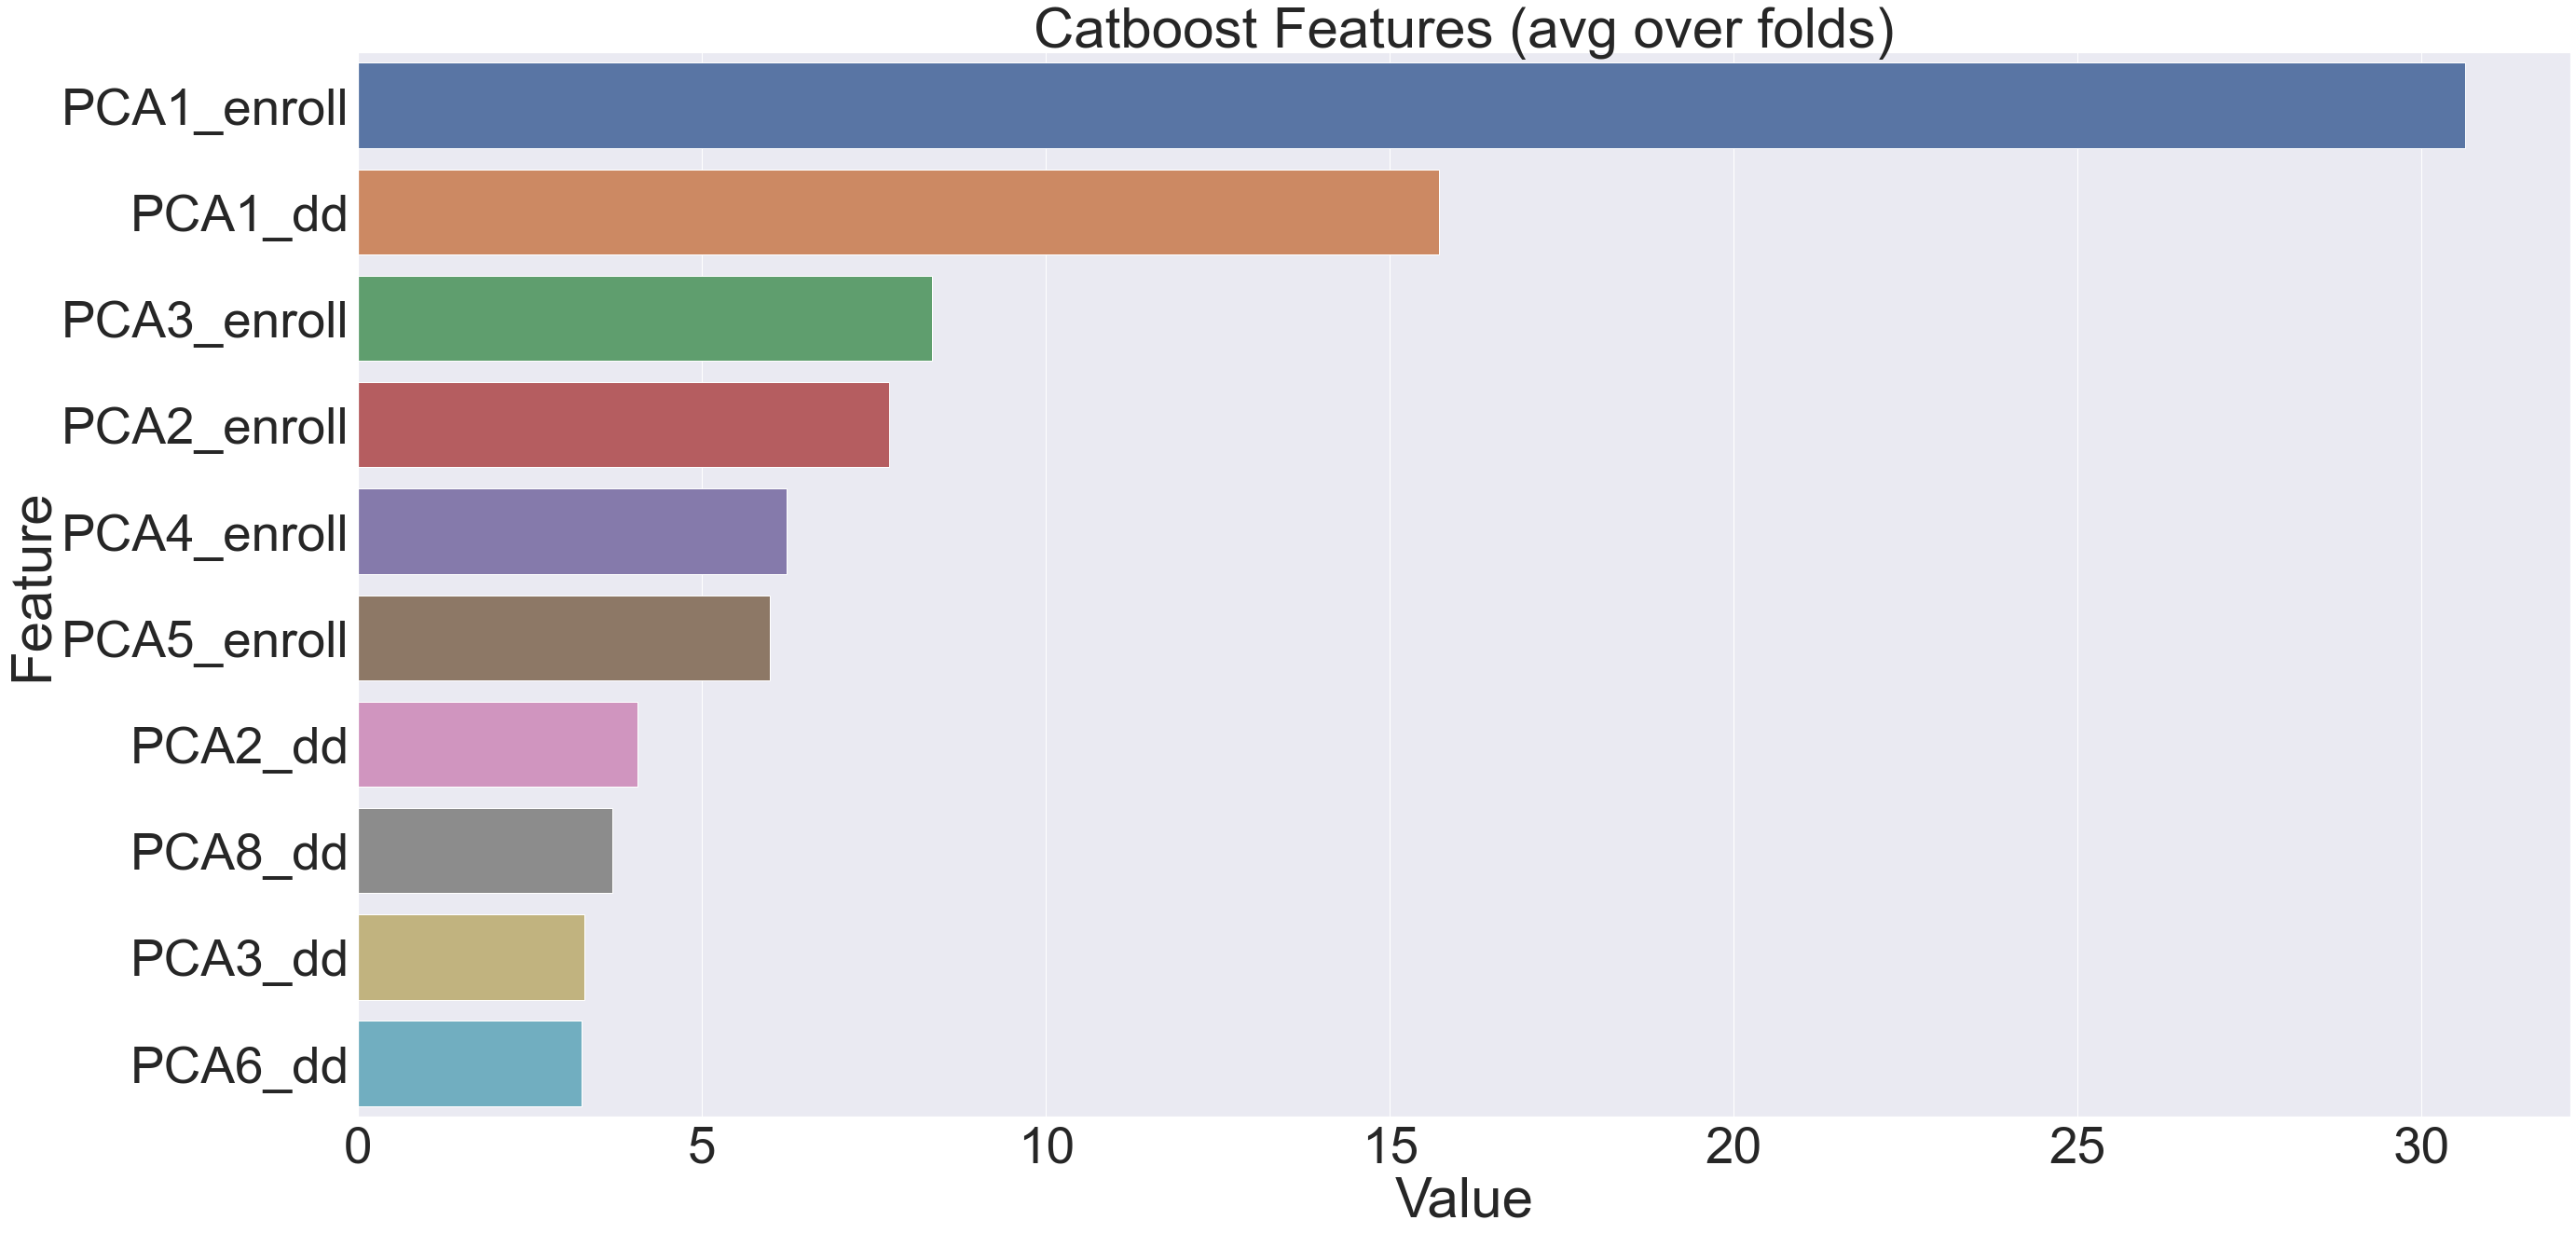

In [113]:
plotImp(estimator2, X_train_PCA2, num=10, text='Catboost Features (avg over folds)')

In [114]:
##Predict train set
train_predictions_cb = estimator2.predict(X_train_scaled)
##Predict validation set
valid_predictions_cb = estimator2.predict(X_valid_scaled)
##Predict test set
test_predictions_cb = estimator2.predict(X_test_scaled)

In [115]:
print(f"The RMSE for training set is {np.round(np.sqrt(mean_squared_error(y_train, train_predictions_cb)),3)}")
print(f"The RMSE for validation set is {np.round(np.sqrt(mean_squared_error(y_valid, valid_predictions_cb)),3)}")
print(f"The RMSE for test set is {np.round(np.sqrt(mean_squared_error(y_test, test_predictions_cb)),3)}")

The RMSE for training set is 5.208
The RMSE for validation set is 8.298
The RMSE for test set is 8.31


**RandomForest**

In [116]:
# estimator = RandomForestRegressor(criterion='mse',
#                            max_features='auto',
#                            random_state=100,
#                            n_jobs=-1)

# def rf_parameter(X_data, y_data):
#     n_estimators = [int(x) for x in np.linspace(100, 1000, 200)]
#     max_depth = [int(x) for x in np.linspace(5, 110, 11)]
#     max_features = ['auto', 'sqrt']
#     min_samples_split = [2, 5, 10]
#     min_samples_leaf = [1, 2, 4]
#     bootstrap = [True, False]

#     param_grid = {'n_estimators': n_estimators,
#                   'max_depth': max_depth,
#                   'max_features': max_features,
#                   'min_samples_split' : min_samples_split,
#                   'min_samples_leaf' : min_samples_leaf,
#                   'bootstrap' : bootstrap}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=KFold(10, shuffle=True, random_state=123),
#                             scoring="neg_mean_squared_error", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data)
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = rf_parameter(X_train_scaled, y_train.values.flatten())
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

# Best parameters: {'n_estimators': 583, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}
# Time consumed for training: 4995.130 seconds

In [117]:
estimator3 = RandomForestRegressor(criterion='mse', max_features='sqrt', random_state=100,
                                   n_estimators = 583, min_samples_split = 10, min_samples_leaf = 1,
                                   max_depth = 15, bootstrap = False,
                                   n_jobs=-1)

In [118]:
estimator3.fit(X_train_scaled, y_train.values.flatten())

RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=10, n_estimators=583, n_jobs=-1,
                      random_state=100)

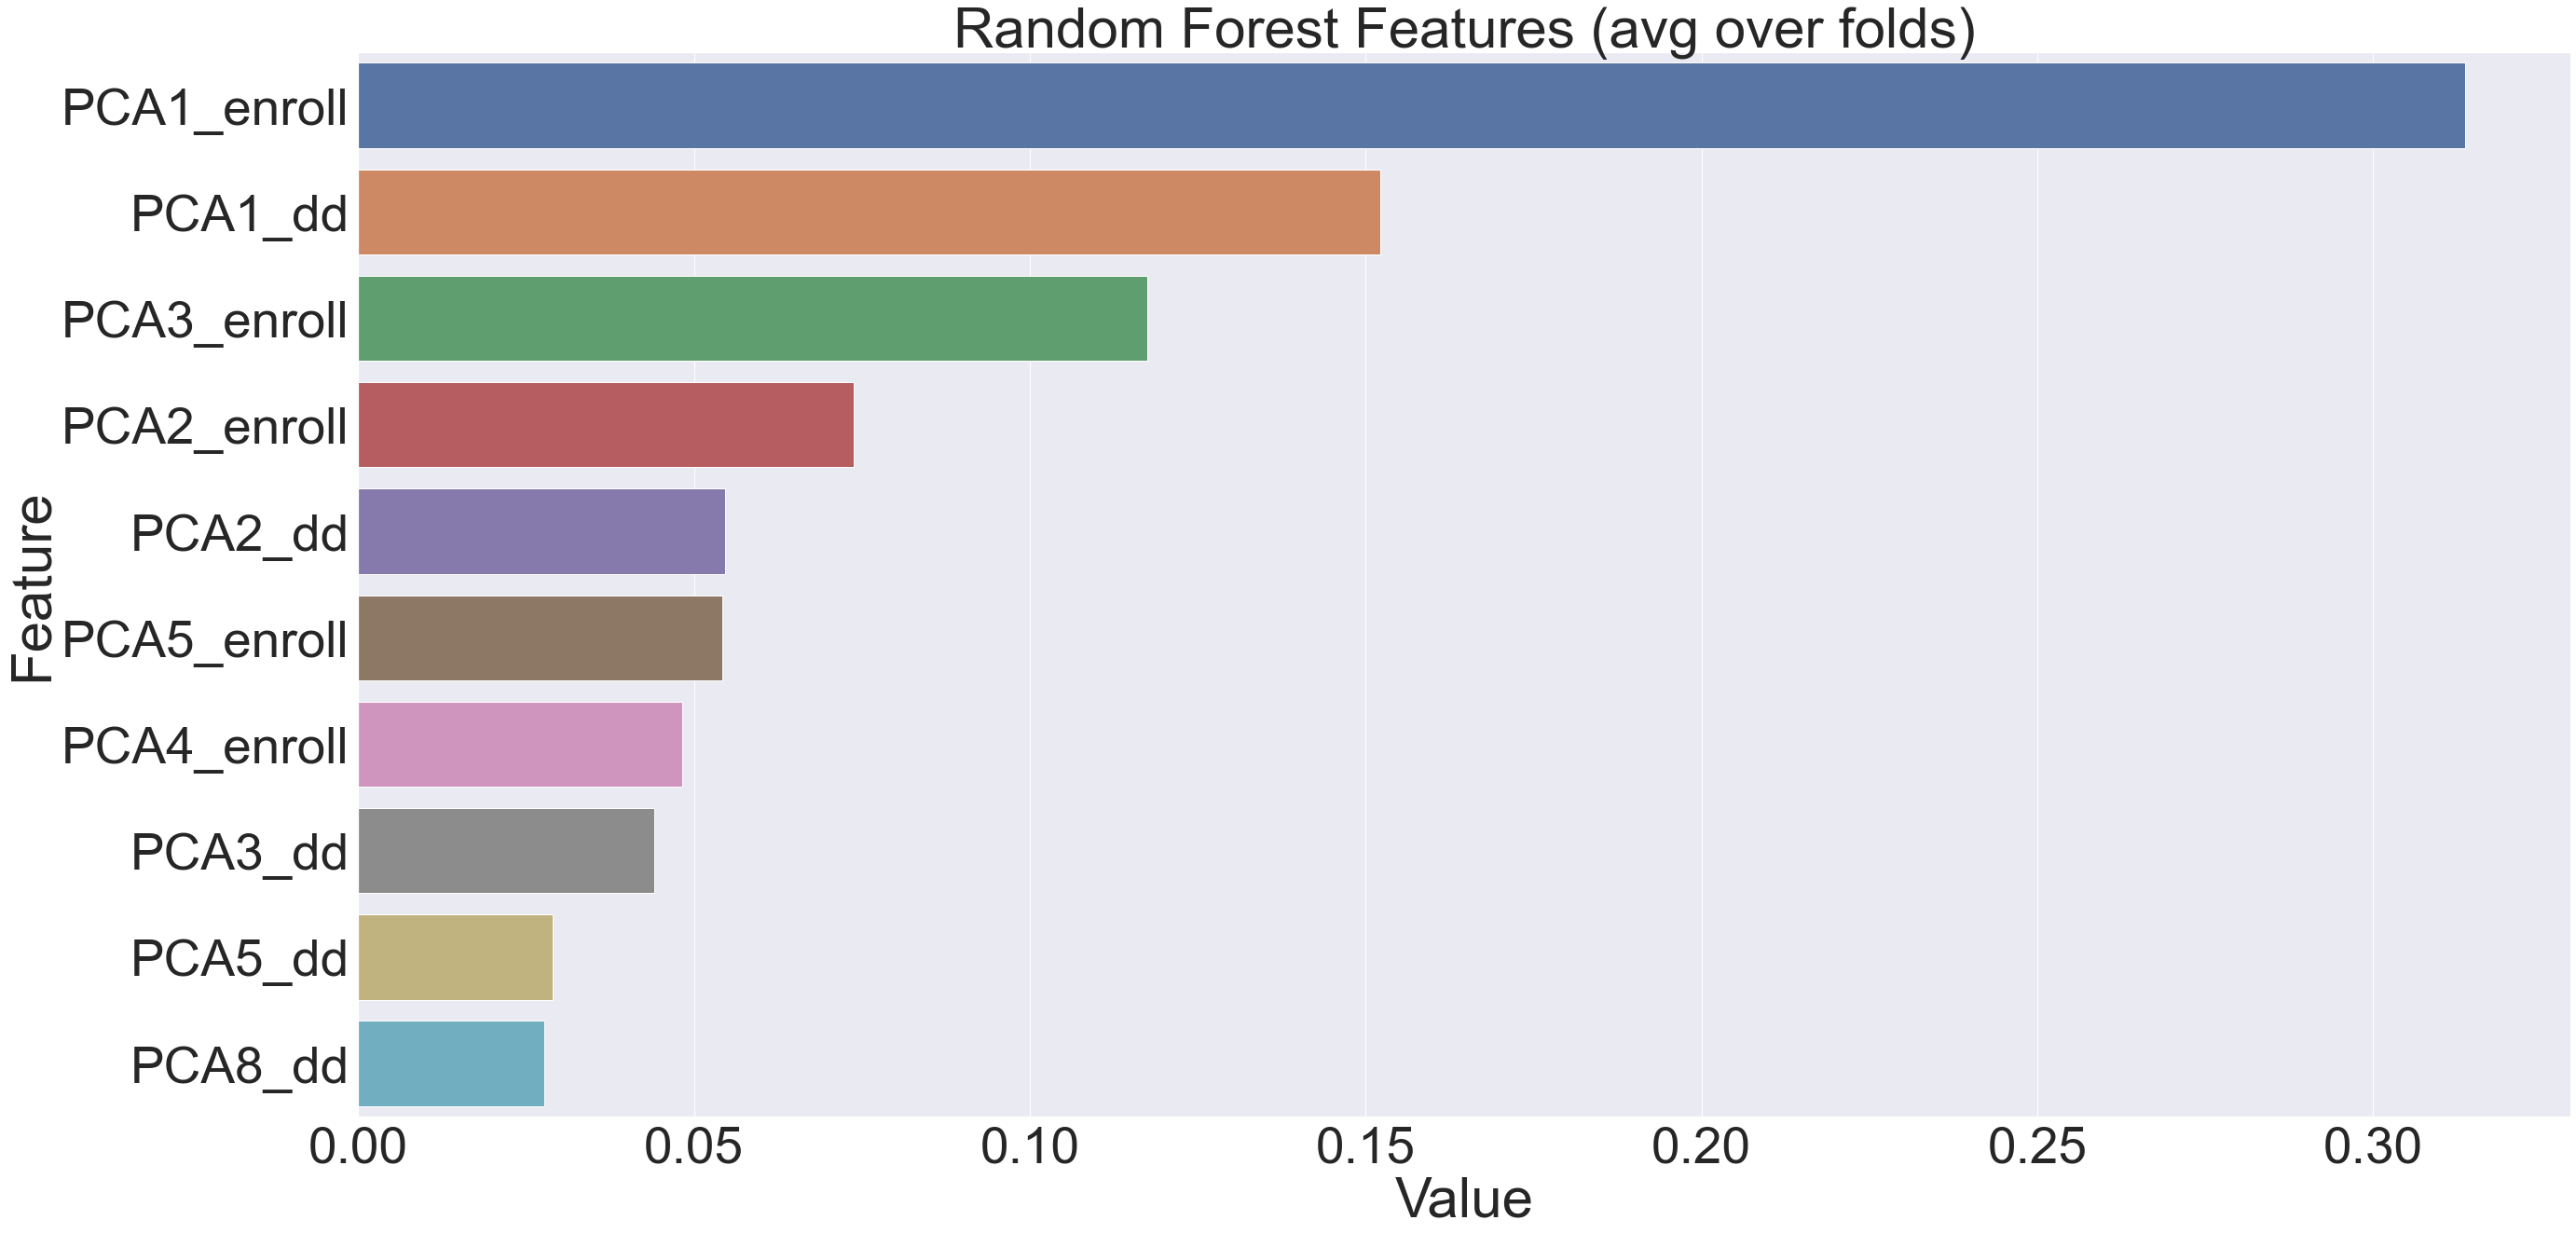

In [119]:
plotImp(estimator3, X_train_PCA2, num=10, text='Random Forest Features (avg over folds)')

In [120]:
##Predict train set
train_predictions_rf = estimator3.predict(X_train_scaled)
##Predict validation set
valid_predictions_rf = estimator3.predict(X_valid_scaled)
##Predict test set
test_predictions_rf = estimator3.predict(X_test_scaled)

In [121]:
print(f"The RMSE for training set is {np.round(np.sqrt(mean_squared_error(y_train, train_predictions_rf)),3)}")
print(f"The RMSE for validation set is {np.round(np.sqrt(mean_squared_error(y_valid, valid_predictions_rf)),3)}")
print(f"The RMSE for test set is {np.round(np.sqrt(mean_squared_error(y_test, test_predictions_rf)),3)}")

The RMSE for training set is 3.896
The RMSE for validation set is 8.273
The RMSE for test set is 8.388


**KNN**

In [122]:
from sklearn.neighbors import KNeighborsRegressor

In [123]:
# def build_classifier(X_train_data, y_train_data, X_test_data, y_test_data, text="ABC"):
#     neighbors = list(range(1, 50, 2))
#     cv_score = []

#     for k in neighbors:
#         knn = KNeighborsRegressor(n_neighbors=k)
#         scores = cross_val_score(estimator=knn, X=X_train_data, y=y_train_data, cv=KFold(10), 
#                                  scoring="neg_mean_squared_error")
#         cv_score.append(scores.mean())

#     MSE = [1- x for x in cv_score]

#     optimal_k = neighbors[MSE.index(min(MSE))]

#     fig = plt.figure(figsize=(12,5))
#     sns.set(font_scale = 2)
#     plt.plot(neighbors, MSE, label = 'MSE for each neighbour')
#     plt.ylabel('Mean Squared Error', fontsize = 12)
#     plt.xlabel('K Size', fontsize = 12)
#     plt.title('The optimal value of neighbor is at: ' + str(optimal_k), fontsize = 14, y = 1.03)
#     plt.legend()
#     plt.grid()
#     plt.show()

In [124]:
# build_classifier(X_train_scaled, y_train.values.flatten(), X_valid_scaled, y_valid.values.flatten(), text='KNN Features (avg over folds)')

In [125]:
estimator4 = KNeighborsRegressor(n_neighbors=7, n_jobs=-1)

In [126]:
estimator4.fit(X_train_scaled, y_train.values.flatten())

KNeighborsRegressor(n_jobs=-1, n_neighbors=7)

In [127]:
##Predict train set
train_predictions_knn = estimator4.predict(X_train_scaled)
##Predict validation set
valid_predictions_knn = estimator4.predict(X_valid_scaled)
##Predict test set
test_predictions_knn = estimator4.predict(X_test_scaled)

In [128]:
print(f"The RMSE for training set is {np.round(np.sqrt(mean_squared_error(y_train, train_predictions_knn)),3)}")
print(f"The RMSE for validation set is {np.round(np.sqrt(mean_squared_error(y_valid, valid_predictions_knn)),3)}")
print(f"The RMSE for test set is {np.round(np.sqrt(mean_squared_error(y_test, test_predictions_knn)),3)}")

The RMSE for training set is 8.668
The RMSE for validation set is 9.849
The RMSE for test set is 10.173


**Merge lightgbm results with index of imported data**

In [129]:
pred_data_trainset = pd.DataFrame(train_predictions_lgbm, columns=['y_pred'])

pred_data_trainset.index = y_train.index.values.tolist()

pred_data_trainset = pd.merge(X_train, pred_data_trainset, left_index=True, right_index=True)

pred_data_trainset = pd.merge(pred_data_trainset, y_train, left_index=True, right_index=True)

pred_data_trainset.shape

(4296, 25)

In [130]:
pred_data_validset = pd.DataFrame(valid_predictions_lgbm, columns=['y_pred'])

pred_data_validset.index = y_valid.index.values.tolist()

pred_data_validset = pd.merge(X_valid, pred_data_validset, left_index=True, right_index=True)

pred_data_validset = pd.merge(pred_data_validset, y_valid, left_index=True, right_index=True)

pred_data_validset.shape

(921, 25)

In [131]:
pred_data_testset = pd.DataFrame(test_predictions_lgbm, columns=['y_pred'])

pred_data_testset.index = y_test.index.values.tolist()

pred_data_testset = pd.merge(X_test, pred_data_testset, left_index=True, right_index=True)

pred_data_testset = pd.merge(pred_data_testset, y_test, left_index=True, right_index=True)

pred_data_testset.shape

(921, 25)

In [132]:
data_a = pd.concat([pred_data_trainset, pred_data_validset], axis=0, ignore_index=False)

In [133]:
data_b = pd.concat([data_a, pred_data_testset], axis=0, ignore_index=False)

In [134]:
data_b.shape

(6138, 25)

In [135]:
dataset_final = pd.merge(data_b, dataset[["school_id_masked", "ben_date"]], left_index=True, right_index=True)

In [136]:
pred_data_trainset.to_csv("pred_data_trainset.csv")
pred_data_validset.to_csv("pred_data_validset.csv")
pred_data_testset.to_csv("pred_data_testset.csv")

In [137]:
del data_b, data_a, pred_data_trainset, pred_data_validset, pred_data_testset

In [138]:
dataset_final.sort_index(axis = 0, inplace=True)

In [139]:
dataset_final.shape

(6138, 27)

In [140]:
dataset_final.head()

,censored,s_1_5_boys,s_1_5_girls,s_6_8_boys,s_6_8_girls,loc_type,school_grp,Month,Day,Week,...,prop_grp_boys68,prop_grp_girls68,prop_wk_boys15,prop_wk_girls15,prop_wk_boys68,prop_wk_girls68,y_pred,mixed_demand,school_id_masked,ben_date
0,1,174,120,129,92,Urban,ZYD,12,29,53,...,0.02,0.02,0.01,0.01,0.01,0.01,38.504652,41.60,ZYD-CU8,12/29/2014
1,0,174,120,129,92,Urban,ZYD,3,7,10,...,0.02,0.02,0.03,0.04,0.03,0.04,23.976524,19.12,ZYD-CU8,3/7/2015
2,0,174,120,129,92,Urban,ZYD,6,8,24,...,0.02,0.02,0.04,0.04,0.04,0.04,8.476445,7.91,ZYD-CU8,6/8/2015
3,1,174,120,129,92,Urban,ZYD,6,11,24,...,0.02,0.02,0.04,0.04,0.04,0.04,27.819667,17.80,ZYD-CU8,6/11/2015
4,0,174,120,129,92,Urban,ZYD,6,15,25,...,0.02,0.02,0.03,0.02,0.03,0.03,18.335397,2.58,ZYD-CU8,6/15/2015


In [141]:
dataset_final.to_csv("dataset_final.csv")

**Thank You**